<a href="https://colab.research.google.com/github/skamble91/ML-Projects/blob/master/AI_ML_Capstone_Shweta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition 
 Background

AAA Northeast is one of the regional clubs comprising the American Automobile Association. AAA Northeast covers Rhode Island, Connecticut, Massachusetts and portions of New York and New Jersey. The American Automobile Association has 58 million members in the US and Canada. They offer services such as roadside assistance, maps and various discounts as part of their services. Roadside assistance is a costly benefit, particularly towing. Members who frequently use roadside assistance are less desirable.

AAA also offers other paid services at highly competitive prices. They also offer insurance, travel and banking/loan products. AAA would like to increase the penetration of these services.

A member may have a standard membership or a premium membership covering themselves and optionally additional household members. Many of AAA members typically have a long tenure with the club.

Objectives

Provide a market segmentation of AAA members (or member households) that allows AAA Northeast to better serve their members. They would use this analysis to:

    Better anticipate the needs of members
    Customize communications and offering to various segments
    Expend more effort driving acquisition and renewal of desirable members

We'll work with the members at the household level.



In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fbprophet

member_df=pd.read_csv("member_sample.csv", index_col=0)
member_df.head()
member_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21344 entries, 0 to 99998
Columns: 112 entries, Individual Key to Was Towed To AAR Referral
dtypes: float64(35), object(77)
memory usage: 18.4+ MB


# Importing data and exploring it to get insights
We have been given an excel file with 116 columns and 21000 rows. The first step would be to analyze the data for   


1.   missing values and accounting for them
2.   looking at data types and cardinality
3.   Looking at correlation
4.   Plotting different graphs

This will help us form an opinion about the data


# Missing Data


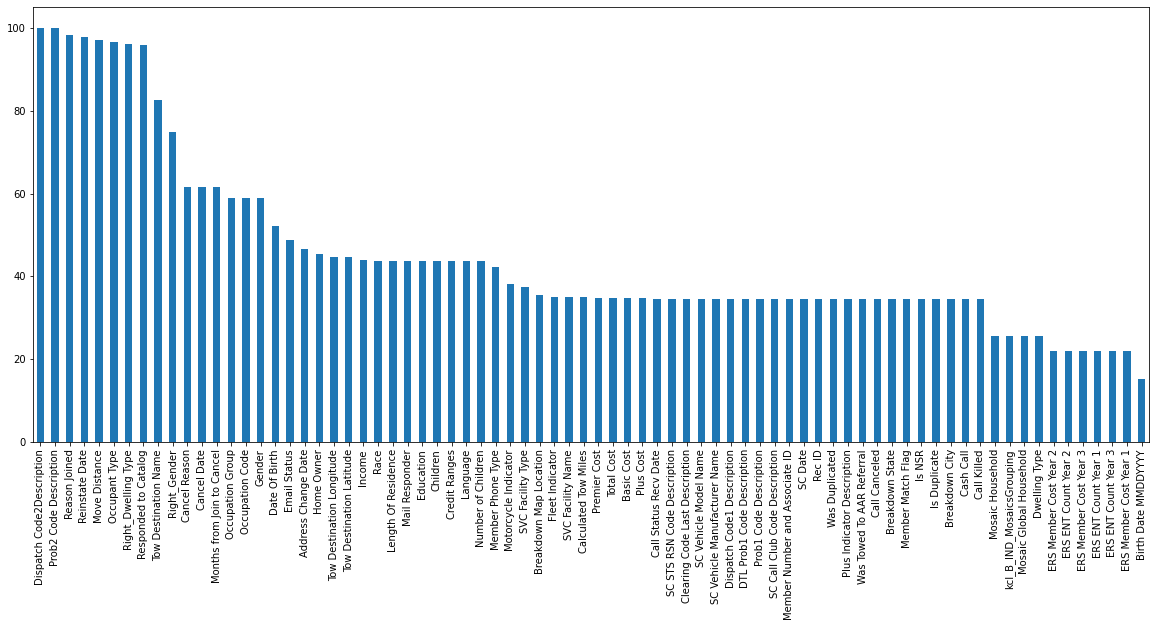

In [ ]:
#underdstanding missing data using %
nulls_percent=member_df.isnull().sum()/len(member_df)*100
nulls_percent=nulls_percent[nulls_percent>2]
nulls_percent.nlargest(100).plot(kind="bar", figsize=(20,8))

You can see very quickly that there is a lot of missing values, we will tackle key variables that will be required at a later time.

It now makes sense to break down the analysis into member, record ID and household level. 

#Data Cleaning and functions
We need to deal with missing data and also build functions to deal with certain data types. Performing those functions now

In [ ]:
#Missing Data cleaning

#Filling in missing date data can be done in various ways, figuring out which one to use 
member_df['Number of Children'].fillna(0, inplace=True)
member_df['Gender'].fillna('Unknown', inplace=True)
member_df['Gender'].value_counts()
member_df['Race'].fillna('Unknown ', inplace=True) #
print(member_df['Race'].value_counts())
member_df['Member Tenure Years'].dropna() # as only 1 with NA



Unknown                                   9334
Caucasion / White - European              5291
Caucasion / White - English               2931
Caucasion / White - White Non-American    1055
Caucasion / White - Unknown                461
Middle Eastern - Arab                      440
Hispanic - Hispanic Origin                 430
Caucasion / White - Eastern European       343
Unknown                                    297
Hispanic - Portuguese Origin               295
Caucasion / White - Jewish                 133
Caucasion / White - Greek                   91
Asian - Chinese                             76
American Indian                             40
African American - African Origin           32
Asian - Indian                              25
Asian - Unknown                             24
Asian - Japanese                            20
Middle Eastern - Egyptian                   12
Caucasion / White - Dutch                   10
Asian - Oriental                             4
Name: Race, d

1        49.0
2        49.0
3        49.0
4        49.0
5        49.0
         ... 
99994    54.0
99995    54.0
99996    54.0
99997    54.0
99998    54.0
Name: Member Tenure Years, Length: 21343, dtype: float64

In [ ]:
print(member_df['TRV Globalware Flag'].isnull().sum())
print(member_df['INS Client Flag'].isnull().sum())
print(member_df['FSV Credit Card Flag'].isnull().sum())
print(member_df['FSV Deposit Program Flag'].isnull().sum())
print(member_df['FSV Home Equity Flag'].isnull().sum())
print(member_df['FSV ID Theft Flag'].isnull().sum())
print(member_df['FSV Mortgage Flag'].isnull().sum())

0
0
0
0
0
0
0


In [ ]:
#Functions
#converting all Y&N columns to 1 or 0
def y_n_to_num(x):
    if x=='Y':
        return 1
    else:
        return 0

member_df['Call Canceled']=member_df['Call Canceled'].apply(y_n_to_num)
member_df['Cash Call']=member_df['Cash Call'].apply(y_n_to_num)


#product mapping
fsvs= [i for i in member_df.columns if i.startswith('FSV')]
for col in fsvs:
    member_df[col]=member_df[col].apply(y_n_to_num)
#other product mapping
member_df['INS Client Flag']=member_df['INS Client Flag'].apply(y_n_to_num)
member_df['TRV Globalware Flag']=member_df['TRV Globalware Flag'].apply(y_n_to_num)


#Converting income into quantative variable for future analysis
 
def mean_income(income):
  income_str=str(income)
  if income_str.endswith('9'):
    min_inc, max_inc=income_str.replace(',','').split('-')
    mean_inc=(int(min_inc)+int(max_inc))/2
    return mean_inc
  elif income=='250K+':
    return 250000
  elif income=='Under 10K':
    return 10000
  else: return 58311.510927 #took the mean of the whole column to fill in NAs

member_df['Income Mean']= member_df['Income'].apply(mean_income)

#Building revenue value
member_df['Plus Indicator Description'].value_counts()
def membership_rev(x):
  if x=='Basic Membership':
    return 54
  elif x=='Plus Membership':
    return 89
  elif x=='Premier Membership':
    return 119
  else: return 89

member_df['Membership Price']=member_df['Plus Indicator Description'].apply(membership_rev)
member_df['Membership Price'].value_counts()

#converting credit ranges to less cardinality buckets
member_df['Credit Ranges'].value_counts()
def credit_bucket(ranges):
  if ranges== '750-799':
    return 3
  elif ranges=='650-699' or ranges=='700-749':
    return 2
  elif ranges=='600-649' or ranges =='550-599':
    return 1
  elif ranges== '500-549' or ranges =='499 & Less':
    return 0
  elif ranges=='800+':
    return 4
  else: return np.nan

member_df['Credit Bucket']=member_df['Credit Ranges'].apply(credit_bucket)
member_df['Credit Bucket'].value_counts()
member_df['Credit Bucket'].fillna((member_df['Credit Bucket'].mean()), inplace=True)

def low2up_case(x):
  return str(x).upper()

member_df['SC Vehicle Manufacturer Name']=member_df['SC Vehicle Manufacturer Name'].apply(low2up_case)
member_df['SC Vehicle Model Name']=member_df['SC Vehicle Model Name'].apply(low2up_case)


#dealing with dates
#looking at date of birth .. looking at nulls and calculating age
from datetime import date
member_df['Birth Date MMDDYYYY']=pd.to_datetime(member_df['Birth Date MMDDYYYY'])
def calculate_age(born):
    today = date.today()
    if type(born)==float:
      return None
    else:
      return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

member_df['Age']=member_df['Birth Date MMDDYYYY'].apply(calculate_age)

#using SC date to get year, month, week
member_df['SC Date']= pd.to_datetime(member_df['SC Date'])
member_df['SC Year'], member_df['SC Month'], member_df['SC Week']=member_df['SC Date'].dt.year, member_df['SC Date'].dt.month, member_df['SC Date'].dt.week
member_df['SC Date Only']=member_df['SC Date'].dt.date

get_unique=lambda x:x.nunique()

#creating age buckets 
def age_buckets(age): 
  if age>12 and age<=18:
    return "Gen Z"
  elif age>18 and age <=39:
    return "millenials"
  elif age>39 and age <=54:
    return "Gen X"
  elif age>54 and age<=73:
    return "Baby Boomers"
  elif age>73:
    return "silent generation"
  else:
    return "data issue"

member_df['Age Buckets']=member_df['Age'].apply(age_buckets)


#looking at subset of columns we will use to create a profile 
member_df['Number of Children'].value_counts()
#member_df['Number of Children'].fillna('unknown', inplace=True)
children=member_df['Number of Children'].value_counts().index
children
num_inst= [0,1,2,3,4,5,6]
member_df['Number of Children']=member_df['Number of Children'].map({c:n for c, n in zip(children, num_inst)})

#looking into Race
import re
#def race_buckets(x):
member_df['Race Bucket']=member_df['Race'].str.extract(r'(\w+\s)')




In [ ]:
member_df[['Individual Key','Household Key','Membership Price','Race Bucket', 'Age Buckets', 'Number of Children', 'Income', 'Credit Bucket', 'FSV Credit Card Flag', 'FSV CMSI Flag',
          'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag'
          ,'Call Canceled', 'Cash Call' ]]

Analysing missing information now 

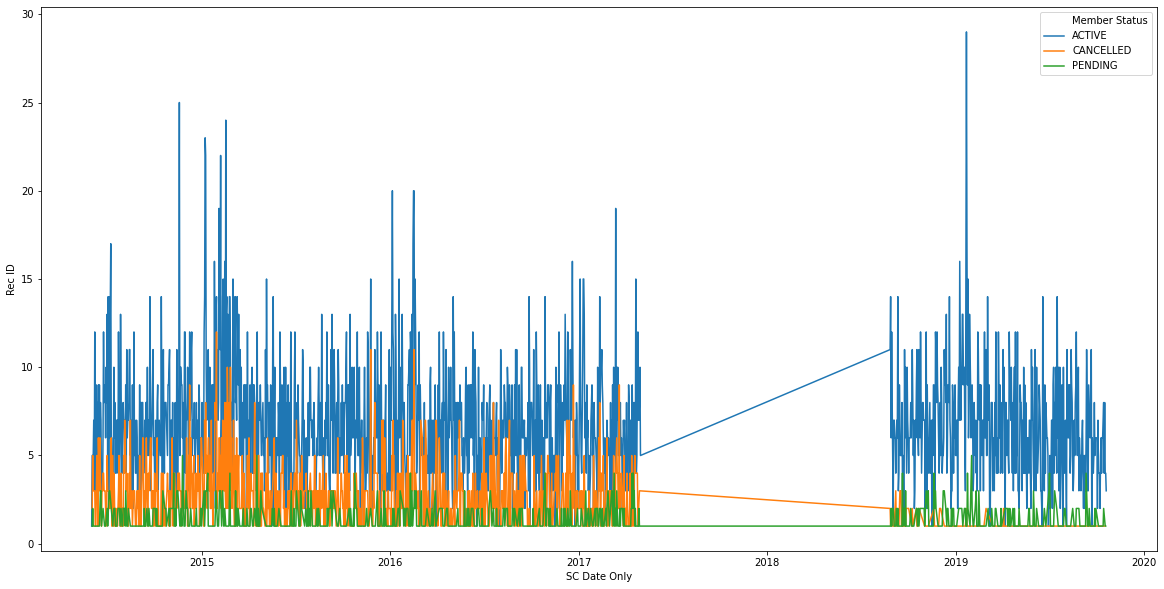

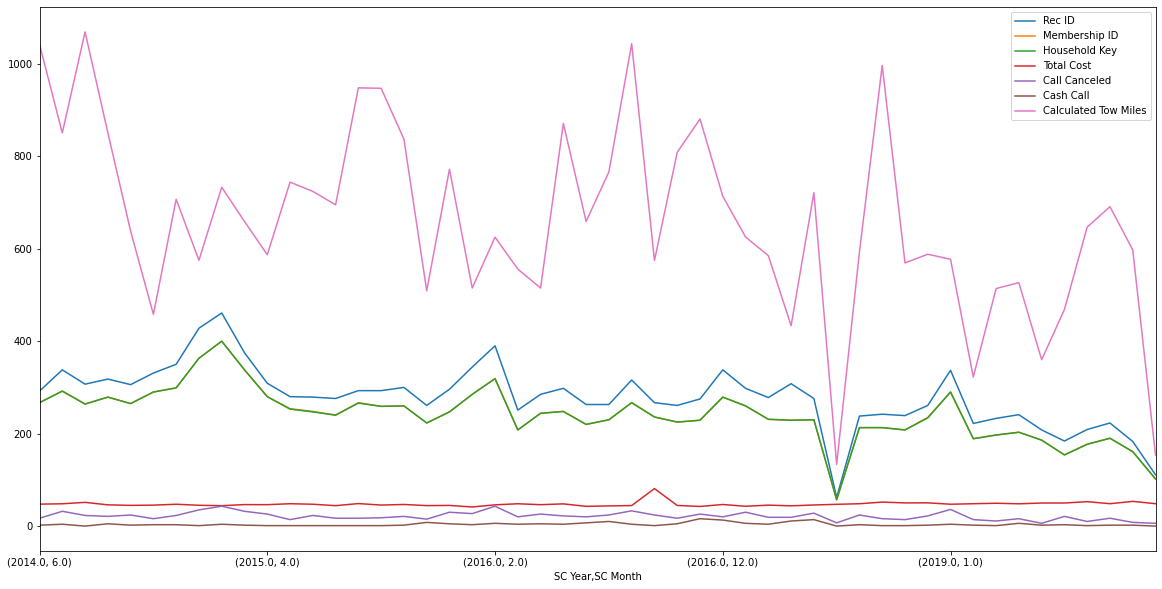

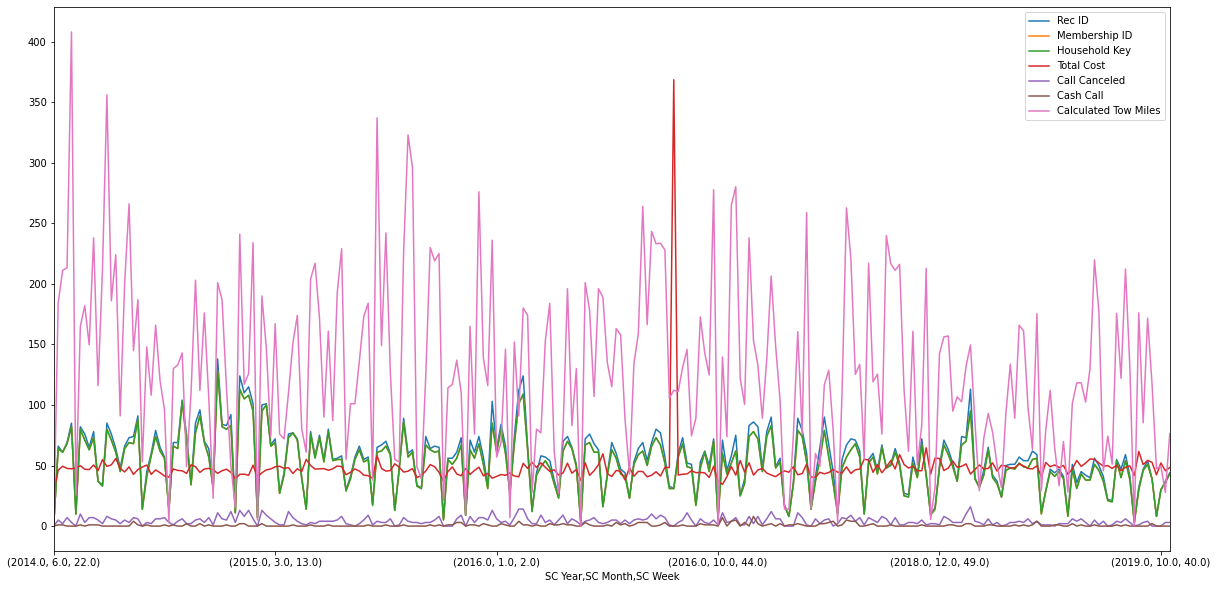

In [ ]:
#Function to change 
get_unique=lambda x:x.nunique()
plt.figure(figsize=(20,10))

date_df=member_df.groupby(['SC Date Only', 'Member Status']).agg({'Rec ID':"count",'Membership ID': lambda x: x.nunique()}).reset_index()
sns.lineplot(x='SC Date Only', y='Rec ID', hue='Member Status', data=date_df)
#sns.lineplot(x='SC Year', y='Rec ID', hue='Member Status', data=member_df)
# there is gap in the data 

#looking at yearly info
member_df.groupby(['SC Year', 'SC Month']).agg({'Rec ID':"count",'Membership ID': get_unique,  'Household Key': get_unique, 'Total Cost': 'mean', 'Call Canceled': 'sum', 'Cash Call': 'sum', 'Calculated Tow Miles': "sum" }).plot(figsize=(20,10))
member_df.groupby(['SC Year', 'SC Month','SC Week']).agg({'Rec ID':"count",'Membership ID': get_unique,  'Household Key': get_unique, 'Total Cost': 'mean', 'Call Canceled': 'sum', 'Cash Call': 'sum', 'Calculated Tow Miles': "sum" }).plot(figsize=(20,10))


At the recID level and on a daily basis there seems to be a significant amount of data missing. 

The data is mising from 4th month of 2017 to 8th month of 2018. Assuming there was a system issue and we lost the data,handling for missing information

There is a huge spike in 2016 for total cost, this will skew the data and values of total cost significantly.

         count       mean        std   min    25%   50%   75%    max
SC Week                                                             
1.0       77.0  42.831169  15.734142   0.0  28.00  53.0  53.0   87.0
2.0       54.0  40.833333  16.386545   0.0  30.00  53.0  53.0   67.0
3.0       66.0  42.984848  15.111374   0.0  30.00  53.0  53.0   74.0
4.0       49.0  41.367347  19.803928   0.0  30.00  53.0  53.0  119.0
5.0       57.0  44.438596  17.223341   0.0  29.00  53.0  53.0  118.0
6.0       81.0  43.641975  15.837699   0.0  30.00  53.0  53.0   53.0
7.0      101.0  52.128713  44.698694   0.0  30.00  53.0  53.0  193.0
8.0       54.0  48.518519  32.924007   0.0  30.00  53.0  53.0  193.0
9.0       43.0  53.581395  37.213818   0.0  30.00  53.0  53.0  193.0
10.0      38.0  59.368421  41.032236  26.0  45.50  53.0  53.0  193.0
11.0      46.0  49.347826  21.916222   0.0  33.50  53.0  53.0  138.0
12.0      38.0  50.447368  27.239377  26.0  30.00  53.0  53.0  185.0
13.0      42.0  47.833333  13.9439

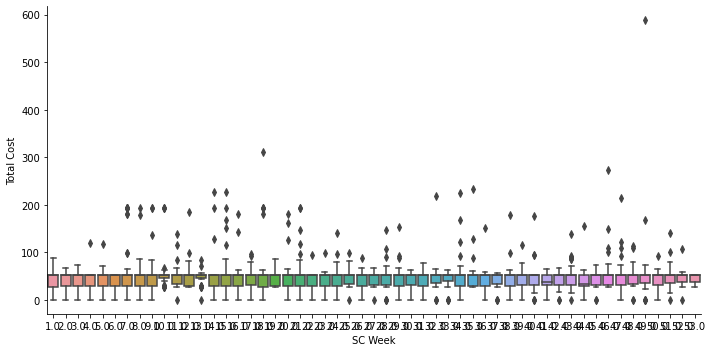

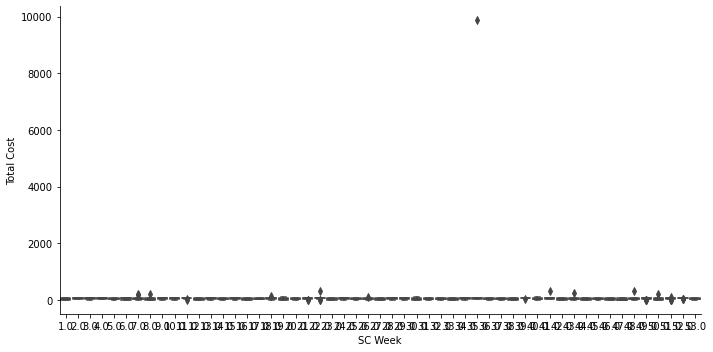

In [ ]:
#looking at box plots for 2016 data




member_df_16=member_df[(member_df['SC Year']==2016) & (member_df['Member Status']!= 'CANCELLED')]
sns.catplot(x="SC Week", y="Total Cost", kind="box",aspect=2,data=member_df_16)
print(member_df_16.groupby([ 'SC Week'])['Total Cost'].describe())
member_df_16_cancelled=member_df[(member_df['SC Year']==2016) & (member_df['Member Status']== 'CANCELLED')]
print(member_df_16_cancelled.groupby([ 'SC Week'])['Total Cost'].describe())
sns.catplot(x="SC Week", y="Total Cost", kind="box",aspect=2,data=member_df_16_cancelled)
#sns.catplot(x="Age Buckets", y="Total Cost",  hue="Member Status", col="SC Year",kind="box",aspect=2,data=member_df_16_cancelled)
#outlier is coming from cancelled call
#looking into reasons cancelled

# cancel reason is at the membership level and cost structure is a little ambiguous
member_df_16_cancelled[member_df_16_cancelled['SC Week']==35.0].groupby(['Cancel Reason', 'Rec ID']).agg({'Rec ID':lambda x:x.nunique() , 'Total Cost': 'sum'})
member_df=member_df[member_df['Rec ID']!=6033663.0]





Clearly the outlier is coming from incorrect data entry, we can remove that data point

#Record ID level analysis
Record ID seems like the most granular level of data
we will like to identify first elements at record ID level, then tackle missing values for important columns

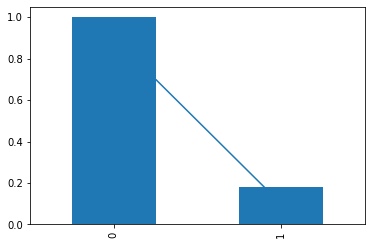

In [ ]:
member_df.groupby(['Household Key','Individual Key', 'Rec ID']).count()
#exploring the first household
member_df[(member_df['Household Key']==875.0) & (member_df['Individual Key']==717785.0)].groupby(['Household Key', 'Individual Key']).nunique()
member_df[(member_df['Household Key']==875.0) & (member_df['Individual Key']==717785.0)]
member_df['TRV Globalware Flag'].value_counts(normalize=True).plot()
member_df['INS Client Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Credit Card Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Deposit Program Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Home Equity Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV ID Theft Flag'].value_counts(normalize=True).plot(kind='bar')
member_df['FSV Mortgage Flag'].value_counts(normalize=True).plot(kind='bar')



Observations of the data from different slices show the columns that seem to be associated with Rec ID are: 
> Breakdown Location, Basic Cost, Calculated Tow Miles, Call Status Recv Date, Cancelled Call, Call Killed, Problem & clearing descriptions, Total Cost, towing destinations etc

Digging into dates and other related quantitative columns

In [ ]:
rec_cols=['Rec ID','Individual Key', 'Basic Cost', 'Calculated Tow Miles', 'Call Status Recv Date', 'Call Canceled', 'Call Killed', 'SC Date', 'Total Cost', 'Premier Cost', 'Plus Cost']

rec_df=member_df[rec_cols]

#profile data
import pandas_profiling as pf
#pf.ProfileReport(rec_df)
member_df['Race Bucket'].value_counts()

Caucasion     10315
Unknown        9333
Hispanic        725
Middle          452
Asian           149
American         40
African          32
Name: Race Bucket, dtype: int64

In [ ]:
rec_nulls=member_df[member_df['Rec ID'].isnull()]
print(member_df[member_df['Rec ID'].isnull()].count())
rec_nulls[['Individual Key','Total Cost','Basic Cost', 'ERS ENT Count Year 1','ERS ENT Count Year 2',
 'ERS ENT Count Year 3',
 'ERS Member Cost Year 1',
 'ERS Member Cost Year 2',
 'ERS Member Cost Year 3',]].count()

rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) |(rec_nulls['ERS ENT Count Year 2'].isnull()) | (rec_nulls['ERS ENT Count Year 3'].isnull()) ].count() #4332
rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) &(rec_nulls['ERS ENT Count Year 2'].isnull()) & (rec_nulls['ERS ENT Count Year 3'].isnull()) ].count()#4332


Individual Key     7347
Household Key      7347
Member Flag        7347
City               7347
State - Grouped    7347
                   ... 
SC Month              0
SC Week               0
SC Date Only          0
Age Buckets        7347
Race Bucket        7290
Length: 122, dtype: int64


Individual Key     4332
Household Key      4332
Member Flag        4332
City               4332
State - Grouped    4332
                   ... 
SC Month              0
SC Week               0
SC Date Only          0
Age Buckets        4332
Race Bucket        4310
Length: 122, dtype: int64

From analysis it seems like this dataset was made from 2 different tables. Rec ID level table and Membership level table. There was a full join made which has caused missing information on both ends. There are customers who do not have rec IDs 7347, this could be because there is missing data or they did not place calls and they are customers who are profitable. 

Digging into membership level now to understand this data 


#Membership Level Analysis

Based on our previous data, we saw that this data seems like a join between membership level and rec ID level. 

There are several members without calls. Trying to understand who those customers are and if it is a missing data issue



In [ ]:
rec_nulls
print(rec_nulls['TRV Globalware Flag'].value_counts(normalize=True)*100)
print(rec_nulls['INS Client Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Credit Card Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Deposit Program Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Home Equity Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV ID Theft Flag'].value_counts(normalize=True)*100)
print(rec_nulls['FSV Mortgage Flag'].value_counts(normalize=True)*100)	 	


no_call_member=rec_nulls[(rec_nulls['ERS ENT Count Year 1'].isnull()) &(rec_nulls['ERS ENT Count Year 2'].isnull()) & (rec_nulls['ERS ENT Count Year 3'].isnull()) ]
no_call_member['Age Buckets'].value_counts()
no_call_member['Number of Children'].value_counts()/len(no_call_member)
no_call_member['Member Tenure Years'].isnull().sum()


0    94.582823
1     5.417177
Name: TRV Globalware Flag, dtype: float64
0    89.152035
1    10.847965
Name: INS Client Flag, dtype: float64
0    96.556418
1     3.443582
Name: FSV Credit Card Flag, dtype: float64
0    99.795835
1     0.204165
Name: FSV Deposit Program Flag, dtype: float64
0    99.959167
1     0.040833
Name: FSV Home Equity Flag, dtype: float64
0    98.679733
1     1.320267
Name: FSV ID Theft Flag, dtype: float64
0    99.945556
1     0.054444
Name: FSV Mortgage Flag, dtype: float64


1

In [ ]:
memberage=member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].count().reset_index()
member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].describe()

count  ...         max
Age Buckets       SC Year Member Status         ...            
Baby Boomers      2014.0  ACTIVE         519.0  ...  10256675.0
                          CANCELLED       89.0  ...  10180091.0
                          PENDING         65.0  ...  10130315.0
                  2015.0  ACTIVE         881.0  ...  10640306.0
                          CANCELLED      129.0  ...  10605735.0
...                                        ...  ...         ...
silent generation 2018.0  CANCELLED       18.0  ...  17329270.0
                          PENDING         28.0  ...  17436788.0
                  2019.0  ACTIVE         609.0  ...  20449552.0
                          CANCELLED       21.0  ...  20429345.0
                          PENDING         57.0  ...  20448457.0

[90 rows x 8 columns]

In [ ]:
member_df_active=member_df.where(member_df['Member Status']=='ACTIVE')
member_df['Age Buckets'].value_counts()
plt.figure(figsize=(20,9))
memberage=member_df.groupby(['Age Buckets', 'SC Year','Member Status'])['Rec ID'].count().reset_index()
sns.catplot(x="Age Buckets", y="Rec ID",  hue="Member Status", col="SC Year",kind="box",data=member_df)
member_df.groupby('Age Buckets')['Total Cost'].describe()


member_df_1819=member_df[((member_df['SC Year']==2018) | (member_df['SC Year']==2019))]
plt.figure(figsize=(25,10))
sns.catplot(x="Age Buckets", y="Total Cost",  hue="Member Status", col="SC Year",kind="box",aspect=2,data=member_df_1819)
print(member_df_1819.groupby(['Age Buckets','Member Status', 'SC Year'])['Total Cost'].describe())



# experimenting with box plots 
plt.figure(figsize=(20,10))
sns.catplot(x="Age Buckets", y="Total Cost",  col="Member Status",kind="box", aspect=1,data=member_df_1819)



In [ ]:
member_df['Motorcycle Indicator'].value_counts()

N    7906
Y    3198
Name: Motorcycle Indicator, dtype: int64

In [ ]:
member_df_dummies=pd.get_dummies(member_df, columns=['SC Year','Race Bucket', 'Gender','Member Status','Motorcycle Indicator'])
member_df_dummies.columns
member_df_dummies.count()

Individual Key             21343
Household Key              21343
Member Flag                21343
City                       21343
State - Grouped            21343
                           ...  
Member Status_ACTIVE       21343
Member Status_CANCELLED    21343
Member Status_PENDING      21343
Motorcycle Indicator_N     21343
Motorcycle Indicator_Y     21343
Length: 138, dtype: int64

In [ ]:

# looking at only active and pending members
active_member_df= member_df[(member_df['Member Status']=='ACTIVE') | (member_df['Member Status']=='PENDING')]

#aggregating Records of instances on member ID level
#active_member_df['SC Year'].value_counts()




member_ads=member_df_dummies.groupby(['Individual Key','Race Bucket_Caucasion ', 'Race Bucket_Hispanic ',
       'Race Bucket_Middle ', 'Race Bucket_Unknown ', 'Race Bucket_African ', 'Race Bucket_American ',
        'Race Bucket_Asian ', 'Gender_Female',
       'Gender_Male', 'Gender_Unknown', 'Member Status_ACTIVE',
       'Member Status_CANCELLED', 'Member Status_PENDING','FSV CMSI Flag', 
       'FSV Credit Card Flag','FSV Deposit Program Flag',  'FSV Home Equity Flag',
       'FSV ID Theft Flag', 'FSV Mortgage Flag','TRV Globalware Flag','INS Client Flag',
       'SC Year_2018.0', 'SC Year_2019.0'	]).agg({'Rec ID':"count",'Total Cost': "mean",
                                                  'Member Tenure Years': "mean",
                                                'ERS Member Cost Year 1': "mean", 
                                                 'ERS Member Cost Year 2':"mean",
                                                'ERS Member Cost Year 3':"mean",
                                                 'ERS ENT Count Year 1': "mean", 
                                                'ERS ENT Count Year 2': "mean",
                                                 'ERS ENT Count Year 3': "mean",
                                                 'Call Canceled': "sum", 
                                                 'Cash Call': "sum",
                                                 'Number of Children': "sum",
                                                 'Income Mean': "mean",
                                                 'Calculated Tow Miles': "mean",
                                                 'Membership Price': "mean",
                                                 'Age': "max",
                                                 'Credit Bucket':'max'}).reset_index()
                                                                                                

#member_ads.drop('FSV Mortgage Flag', inplace=True)
member_ads.fillna(0,inplace=True)
member_ads.set_index('Individual Key', inplace=True)
member_ads

,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag,SC Year_2018.0,SC Year_2019.0,Rec ID,Total Cost,Member Tenure Years,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS Member Cost Year 3,ERS ENT Count Year 1,ERS ENT Count Year 2,ERS ENT Count Year 3,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket
Individual Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17293.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.00,55.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0.0,58311.510927,0.000000,89.0,91.0,2.537858
19897.0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,55.75,35.0,0.0,98.00,301.19,0.0,1.0,3.0,1,0,0.0,58311.510927,2.333333,89.0,53.0,2.537858
19918.0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,32.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0.0,58311.510927,0.000000,89.0,0.0,2.537858
19943.0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,58.85,54.0,0.0,58.85,0.00,0.0,1.0,0.0,0,0,1.0,50044.500000,2.000000,89.0,76.0,4.000000
19959.0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,21.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0,1.0,50044.500000,0.000000,89.0,75.0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212317919.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,28.00,44.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0.0,58311.510927,0.000000,54.0,71.0,2.537858
212320920.0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0.00,48.0,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0.0,58311.510927,0.000000,89.0,93.0,2.537858
212321856.0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,53.00,47.0,0.0,176.55,0.00,0.0,3.0,0.0,0,0,0.0,58311.510927,0.000000,54.0,93.0,2.537858


In [ ]:

pf.ProfileReport(member_ads)

In [ ]:
print(member_ads['TRV Globalware Flag'].value_counts())
print(member_ads['INS Client Flag'].value_counts())
print(member_ads['FSV Credit Card Flag'].value_counts())
print(member_ads['FSV Deposit Program Flag'].value_counts())
print(member_ads['FSV Home Equity Flag'].value_counts())
print(member_ads['FSV ID Theft Flag'].value_counts())
print(member_ads['FSV CMSI Flag'].value_counts())	 	

product_cols=['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag','FSV Home Equity Flag', 
               'FSV ID Theft Flag','TRV Globalware Flag','INS Client Flag']

0    10315
1     1055
Name: TRV Globalware Flag, dtype: int64
0    9559
1    1811
Name: INS Client Flag, dtype: int64
0    10747
1      623
Name: FSV Credit Card Flag, dtype: int64
0    11346
1       24
Name: FSV Deposit Program Flag, dtype: int64
0    11364
1        6
Name: FSV Home Equity Flag, dtype: int64
0    11091
1      279
Name: FSV ID Theft Flag, dtype: int64
0    10896
1      474
Name: FSV CMSI Flag, dtype: int64


In [ ]:
# feature engineer to scale the data 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = member_ads.drop(product_cols, axis=1)
y_new = member_ads['TRV Globalware Flag']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=member_ads.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)
y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have


0    0.914671
1    0.085329
Name: TRV Globalware Flag, dtype: float64

In [ ]:
col_list=list(X_new.columns)
col_list.append("TRV Globalware Flag")
col_list.insert(0,"Individual Key")


In [ ]:
#need sampling method to tackle this issue

import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 5

cat_list=list(range(14)) #categorical features in the dataset there are 15 
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)

#Upsample to get 70% of minority class
from collections import Counter
X_res, y_res =sm.fit_resample(X_train.reset_index(), y_train)
print(sorted(Counter(y_res).items()))


In [ ]:
dict_y=list(Counter(y_res).items())
items=round(dict_y[0][1]*0.7)
items

7083

In [ ]:
#now downsample the majority class randomly

X_Y_res = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
X_Y_res.columns=col_list
X_downsampled=X_Y_res[X_Y_res['TRV Globalware Flag']==0].sample(items)

new_Df=pd.concat([X_Y_res[X_Y_res['TRV Globalware Flag']==1], X_downsampled], axis=0)
new_Df

In [ ]:
corrMatrixoversampled = pd.DataFrame(X_res).corr()
corrMatrix=member_ads.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrix)
plt.figure(figsize=(15,10))
sns.heatmap(corrMatrixoversampled)

In [ ]:
print(X_res.shape)
print(X_test.shape)

(17202, 34)
(2766, 33)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE



def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    Y_probs=model.predict_proba(X_test)
    return y_pred, Y_probs

#smotenc+adaboost
y_smote, ysmote_probs = adaboost(X_res, X_test.reset_index(), y_res)

# RUS + adaboost 
X_full = X_train.copy()
X_full['target'] = y_train
X_maj = X_full[X_full.target==0]
X_min = X_full[X_full.target==1]
X_maj_rus = resample(X_maj,replace=False,n_samples=len(X_min),random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop(['target'], axis=1)
y_train_rus = X_rus.target
y_rus, y_rusprobs = adaboost(X_train_rus, X_test, y_train_rus)
 

#Smotenc+logreg and svm
lr=LogisticRegression(penalty='l2', C=4, dual=False, max_iter=10000)
clf = LinearSVC(penalty='l2', max_iter=500, dual=False, C=10,verbose=1)
clf.fit(X_train, y_train)
lr.fit(X_train,y_train)

print("SVM",clf.score(X_test,y_test))
print("Log Reg",lr.score(X_test,y_test))

y_pred = lr.predict(X_test)
y_predsvm=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_matlr = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matsvm= confusion_matrix(y_true=y_test, y_pred=y_predsvm)
conf_mat_adasmote= confusion_matrix(y_true=y_test, y_pred=y_smote)
conf_mat_rusada= confusion_matrix(y_true=y_test, y_pred=y_rus)
print('Confusion matrix:\n', conf_matlr)
print('Confusion matrix:\n', conf_matsvm)
print('Confusion matrix:\n', conf_mat_adasmote)
print('Confusion matrix:\n', conf_mat_rusada)

target_names = ['Not Bought', 'Bought']

print('log Report:\n',classification_report(y_test, y_pred, target_names=target_names))

print('svm Report:\n',classification_report(y_test, y_predsvm, target_names=target_names))

print('smote ada Report:\n',classification_report(y_test, y_smote, target_names=target_names))
print('rus ada Report:\n',classification_report(y_test, y_rus, target_names=target_names))


'''
[LibLinear]SVM 0.9070860448300795
Log Reg 0.9070860448300795
Confusion matrix:
 [[2509    0]
 [ 257    0]]
 '''
y_pred


In [ ]:

!pip install scikit-plot
import scikitplot as skplot
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
kf = KFold(n_splits=5, random_state=42, shuffle=True)
example_params = {
        'n_estimators': 500,
        'random_state': 13
    }

from sklearn.utils import resample

#col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
#y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have


def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5)

    smoter = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        skplot.metrics.plot_cumulative_gain(y_val_fold, model_obj.predict_proba(X_val_fold))
        skplot.metrics.plot_roc_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        
        skplot.metrics.plot_lift_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        print(confusion_matrix(y_true=y_val_fold, y_pred= model_obj.predict(X_val_fold)))
        print('CV Report:\n',classification_report(y_val_fold,model_obj.predict(X_val_fold), target_names=target_names))
    return np.array(scores)

# Example of the model in action
score_model(AdaBoostClassifier, example_params, cv=kf)

In [ ]:


skplot.metrics.plot_cumulative_gain(y_test, lr.predict_proba(X_test))
skplot.metrics.plot_roc_curve(y_test, lr.predict_proba(X_test))
skplot.metrics.plot_lift_curve(y_test, lr.predict_proba(X_test))

skplot.metrics.plot_cumulative_gain(y_test, ysmote_probs)
skplot.metrics.plot_roc_curve(y_test, ysmote_probs)
skplot.metrics.plot_lift_curve(y_test, ysmote_probs)

skplot.metrics.plot_cumulative_gain(y_test, y_rusprobs)
skplot.metrics.plot_roc_curve(y_test, y_rusprobs)
skplot.metrics.plot_lift_curve(y_test, y_rusprobs)

In [ ]:
X_train.columns

Index(['Race Bucket_Caucasion ', 'Race Bucket_Hispanic ',
       'Race Bucket_Middle ', 'Race Bucket_Unknown ', 'Race Bucket_African ',
       'Race Bucket_American ', 'Race Bucket_Asian ', 'Gender_Female',
       'Gender_Male', 'Gender_Unknown', 'Member Status_ACTIVE',
       'Member Status_CANCELLED', 'Member Status_PENDING', 'FSV Mortgage Flag',
       'SC Year_2018.0', 'SC Year_2019.0', 'Rec ID', 'Total Cost',
       'Member Tenure Years', 'ERS Member Cost Year 1',
       'ERS Member Cost Year 2', 'ERS Member Cost Year 3',
       'ERS ENT Count Year 1', 'ERS ENT Count Year 2', 'ERS ENT Count Year 3',
       'Call Canceled', 'Cash Call', 'Number of Children', 'Income Mean',
       'Calculated Tow Miles', 'Membership Price', 'Age', 'Credit Bucket'],
      dtype='object')

[6.94235103 2.77883839 1.6997662 ]
[0.21147515 0.08464787 0.05177761]
[ 0.00041614  0.00427353  0.00215846 -0.00092387  0.00355002 -0.00649911
 -0.00613704  0.0044007  -0.01138916  0.00518876 -0.00254935 -0.00071008
  0.00718118 -0.00212656 -0.00581357  0.00259554  0.00114894  0.00067774
 -0.00313283 -0.00250383 -0.0044294  -0.00083522 -0.00239399 -0.00456246
 -0.00091135  0.00259384  0.00066507  0.00026765 -0.0050207  -0.00372368
  0.00116361 -0.00349753 -0.00144097]


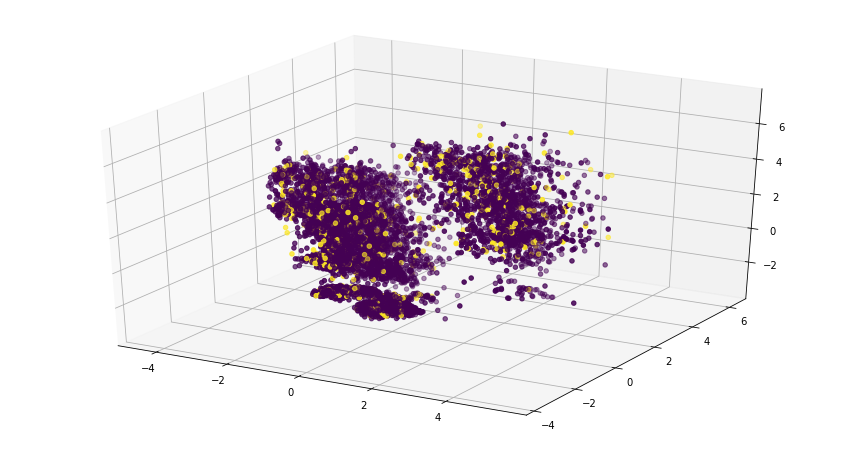

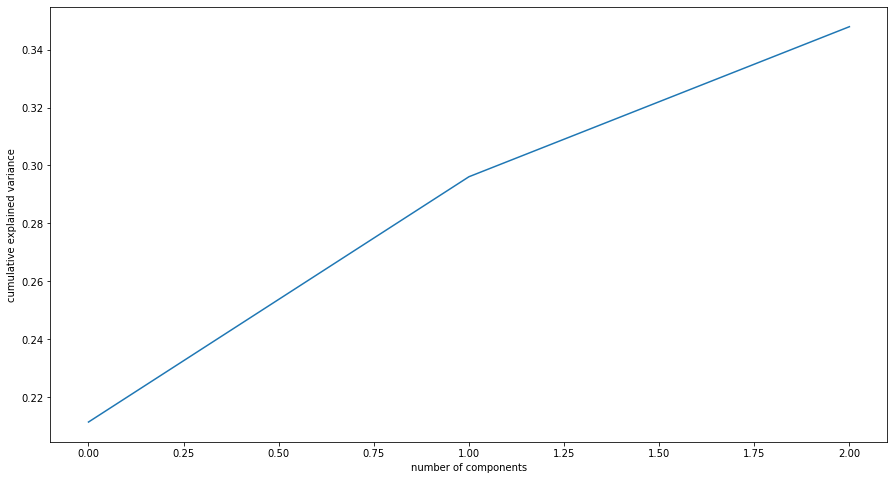

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




pca = PCA(n_components=3)
pca_df = pca.fit_transform(X_train)


def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[:,2], pca_df[:,1],pca_df[:,0] ,c=y_train)
#plot_2d_space(pca_df, y_train, 'Imbalanced dataset (2 PCA components)')
#plot_2d_space()

ax.scatter(pca_df[:,2], pca_df[:,1],pca_df[:,0] ,c=y_train)

#print(pca.components_)
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.mean_)

#print(pca.score)

pca_df


fig=plt.figure(figsize=(15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_trainlda = lda.fit_transform(X_train, y_train)
X_testlda = lda.transform(X_test)
lda.explained_variance_ratio_

array([1.])

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from adaboost

#HouseHold Level Analysis

In [ ]:
#building an analytical dataset for the household- 
#we characterize that to make our purchasing decision since the desparity of classes will be lower
Household_ads=member_df_dummies.groupby(['Household Key']).agg({'Individual Key':'count','Rec ID':"count",'Total Cost': "mean",
                                                  'Member Tenure Years': "mean",
                                               # 'ERS Member Cost Year 1': "mean", 
                                                # 'ERS Member Cost Year 2':"mean",
                                                #'ERS Member Cost Year 3':"mean",
                                                # 'ERS ENT Count Year 1': "mean", 
                                                #'ERS ENT Count Year 2': "mean",
                                                # 'ERS ENT Count Year 3': "mean",
                                                 'Call Canceled': "sum", 
                                                 'Cash Call': "sum",
                                                 'Number of Children': "sum",
                                                 'Income Mean': "mean",
                                                 'Calculated Tow Miles': "sum",
                                                 'Membership Price': "mean",
                                                 'Age': "max",
                                                 'Credit Bucket':'max',
                                                 'Race Bucket_Caucasion ':'sum',
                                                 'Race Bucket_Hispanic ': 'sum'
                                                 ,'Race Bucket_Middle ': 'sum', 
                                                 'Race Bucket_Unknown ': 'sum',
                                                  'Race Bucket_African ': 'sum',
                                                   'Race Bucket_American ': 'sum',
                                                   'Race Bucket_Asian ': 'sum',
                                                    'Gender_Female': 'sum',
                                                    'Gender_Male': 'sum',
                                                     'Gender_Unknown': 'sum',
                                                      'Member Status_ACTIVE': 'sum',
                                                       'Member Status_CANCELLED': 'sum', 
                                                       'Member Status_PENDING': 'sum',
                                                       'FSV CMSI Flag': 'sum',
                                                       'FSV Credit Card Flag': 'sum',
                                                       'FSV Deposit Program Flag': 'sum',
                                                         'FSV Home Equity Flag': 'sum',
                                                         'FSV ID Theft Flag': 'sum',
                                                          'FSV Mortgage Flag': 'sum',
                                                          'TRV Globalware Flag': 'sum',
                                                          'INS Client Flag': 'sum',
                                                  }).reset_index()
                                                                                                

#member_ads.drop('FSV Mortgage Flag', inplace=True)
def flag_prod(x):
  if x>0:return 1
  else: return 0

Household_ads.fillna(0,inplace=True)

product_cols=['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag','FSV Home Equity Flag', 
               'FSV ID Theft Flag','TRV Globalware Flag','INS Client Flag']

In [ ]:
fsvs= [i for i in Household_ads.columns if i.startswith('FSV')]
for col in fsvs:
    Household_ads[col]=Household_ads[col].apply(flag_prod)
#other product mapping
Household_ads['INS Client Flag']=Household_ads['INS Client Flag'].apply(flag_prod)
Household_ads['TRV Globalware Flag']=Household_ads['TRV Globalware Flag'].apply(flag_prod)
Household_ads


,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag
0,875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,1,0,0,0,0,0,0
1,969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0,0,0,0,0,0,1
2,3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0,0,0,0,0,0,0
3,8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,0,0,0,0,0,1,0
4,11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0,0,0,0,0,0,1
5237,100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0,0,0,0,0,0,0
5238,100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0,0,0,0,0,0,0
5239,100071870.0,7,6,35.166667,13.000000,0,0,0.0,58311.510927,9.0,59.000000,100.0,2.537858,0,0,0,7.0,0,0,0,0,0,7.0,0,7.0,0,0,0,0,0,0,0,0,1


In [ ]:
print(Household_ads['TRV Globalware Flag'].value_counts())
print(Household_ads['INS Client Flag'].value_counts())
print(Household_ads['FSV Credit Card Flag'].value_counts())
print(Household_ads['FSV Deposit Program Flag'].value_counts())
print(Household_ads['FSV Home Equity Flag'].value_counts())
print(Household_ads['FSV ID Theft Flag'].value_counts())
print(Household_ads['FSV CMSI Flag'].value_counts())


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Household_ads.drop(product_cols, axis=1)
X_new_temp=X_new.set_index('Household Key')
y_new = Household_ads['TRV Globalware Flag']
transformed_df=pt.fit_transform(X_new.set_index('Household Key'))
transformed_df=pd.DataFrame(transformed_df, index=X_new_temp.index, columns=X_new.set_index('Household Key').columns)
#transformed_df.columns=X_new.columns

col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)
y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have
transformed_df
X_train

0    4510
1     731
Name: TRV Globalware Flag, dtype: int64
0    3800
1    1441
Name: INS Client Flag, dtype: int64
0    4663
1     578
Name: FSV Credit Card Flag, dtype: int64
0    5213
1      28
Name: FSV Deposit Program Flag, dtype: int64
0    5235
1       6
Name: FSV Home Equity Flag, dtype: int64
0    5006
1     235
Name: FSV ID Theft Flag, dtype: int64
0    4873
1     368
Name: FSV CMSI Flag, dtype: int64


,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag
3944,16616199.0,-1.450415,-1.181811,-1.291825,0.620867,-0.402277,-0.130681,-0.314398,0.806857,-0.679271,0.641213,-0.106266,-2.672082,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,-0.652816,-1.556380,-0.028711,-1.339634,-0.294012,-0.045861
1414,5144534.0,-0.494113,-0.154194,0.868485,0.582826,-0.402277,-0.130681,0.640923,-0.110935,-0.679271,0.641213,0.433402,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,0.016055,-0.294012,-0.045861
1951,7295976.0,-0.494113,-1.181811,-1.291825,-1.845629,-0.402277,-0.130681,0.141705,-2.215077,-0.679271,0.641213,-0.170611,-1.146150,-1.105988,-0.219067,5.786213,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-1.128362,0.016055,3.398949,-0.045861
3456,13728273.0,-1.450415,-1.181811,-1.291825,0.469071,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.643503,-0.281583,-1.105988,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,-0.345496,-1.128362,0.016055,-0.294012,-0.045861
45,195448.0,0.075152,0.350441,0.868485,-0.004839,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.106266,-0.281583,-1.105988,-0.219067,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.684396,0.487968,0.016055,-0.294012,-0.045861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,40682673.0,-0.494113,0.350441,0.565305,0.850354,-0.402277,-0.130681,0.141705,-2.755534,1.531958,0.641213,0.575188,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.611069,-1.556380,0.487968,-1.339634,-0.294012,-0.045861
3264,13029984.0,1.532353,1.593411,0.847759,-0.346818,2.490646,-0.130681,-1.238934,0.221013,1.735424,-1.665352,0.575188,-0.281583,-1.105988,-0.219067,-0.172825,2.053379,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,1.917640,1.333967,-1.339634,3.402636,-0.045861
1653,6117070.0,1.626365,1.217538,0.886138,-1.259888,-0.402277,-0.130681,0.929371,0.552744,1.616179,-0.837821,-0.421009,-0.281583,1.435184,-0.219067,-0.172825,1.474676,-0.06032,-0.051753,-0.102983,1.737876,-0.652816,1.213923,1.333967,1.659804,-0.294012,-0.045861
2607,10052163.0,-0.494113,-1.181811,-1.291825,-0.054087,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.718186,-0.281583,-1.105988,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.277089,-0.028711,0.016055,-0.294012,-0.045861


In [ ]:
'''

from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report


kf = KFold(n_splits=5, random_state=42, shuffle=True)
example_params = {
        'n_estimators': 500,
        'random_state': 13
    }

#col_list=list(X_new.columns).append('TRV Globalware Flag')
#splitting into training and test
#y_train.value_counts(normalize=True) #91% of members havent bought the product but 8% have
target_names=["bought", "not bought"]

def score_model(model, params, cv=None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    """
    if cv is None:
        cv = KFold(n_splits=5)

    smoter = SMOTE(sampling_strategy=0.7, k_neighbors=3, random_state=15)
    
    scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        skplot.metrics.plot_cumulative_gain(y_val_fold, model_obj.predict_proba(X_val_fold))
        skplot.metrics.plot_roc_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        
        skplot.metrics.plot_lift_curve(y_val_fold, model_obj.predict_proba(X_val_fold))
        print(confusion_matrix(y_true=y_val_fold, y_pred= model_obj.predict(X_val_fold)))
        print('CV Report:\n',classification_report(y_val_fold,model_obj.predict(X_val_fold), target_names=target_names))
    return np.array(scores)

# Example of the model in action
score_model(AdaBoostClassifier, example_params, cv=kf)


'''

Classifier for TRV Globalware Flag

In [ ]:
!pip install xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [2,  8, 10,100],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.963506 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.017687 (0.017629) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 2}
0.769463 (0.059198) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.821393 (0.050418) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 10}
0.963506 (0.021222) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.044253 (0.024404) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 2}
0.697495 (0.061037) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.762177 (0.059037

[[111 810]
 [  4 124]]
              precision    recall  f1-score   support

  Not Bought       0.97      0.12      0.21       921
      Bought       0.13      0.97      0.23       128

    accuracy                           0.22      1049
   macro avg       0.55      0.54      0.22      1049
weighted avg       0.86      0.22      0.22      1049



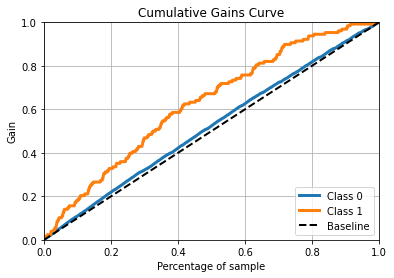

In [ ]:
#Best: 0.760046 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}

#Best: 0.963506 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_cumulative_gain(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))


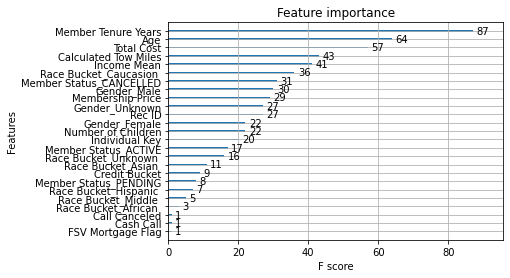

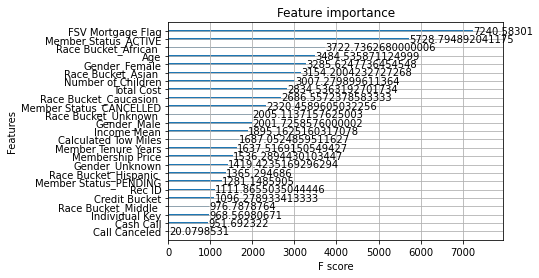

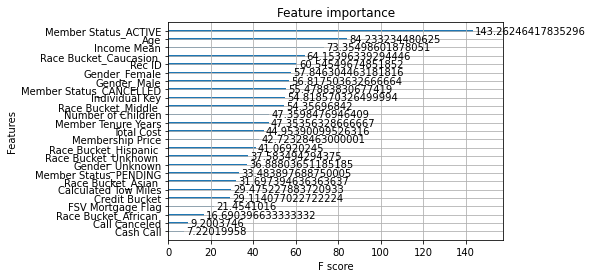

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result.predict(X_test.set_index('Household Key'))
confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure


ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure

ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure



##Mortgage Likelihood model


In [ ]:
print(product_cols)
print(Household_ads['FSV CMSI Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV CMSI Flag']
col_list=list(X_new.columns).append('FSV CMSI Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)
X_train

['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.929784
1    0.070216
Name: FSV CMSI Flag, dtype: float64


,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag
3944,16616199.0,-1.450415,-1.181811,-1.291825,0.620867,-0.402277,-0.130681,-0.314398,0.806857,-0.679271,0.641213,-0.106266,-2.672082,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,-0.652816,-1.556380,-0.028711,-1.339634,-0.294012,-0.045861
1414,5144534.0,-0.494113,-0.154194,0.868485,0.582826,-0.402277,-0.130681,0.640923,-0.110935,-0.679271,0.641213,0.433402,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,0.016055,-0.294012,-0.045861
1951,7295976.0,-0.494113,-1.181811,-1.291825,-1.845629,-0.402277,-0.130681,0.141705,-2.215077,-0.679271,0.641213,-0.170611,-1.146150,-1.105988,-0.219067,5.786213,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-1.128362,0.016055,3.398949,-0.045861
3456,13728273.0,-1.450415,-1.181811,-1.291825,0.469071,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.643503,-0.281583,-1.105988,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,-0.345496,-1.128362,0.016055,-0.294012,-0.045861
45,195448.0,0.075152,0.350441,0.868485,-0.004839,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.106266,-0.281583,-1.105988,-0.219067,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.684396,0.487968,0.016055,-0.294012,-0.045861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,40682673.0,-0.494113,0.350441,0.565305,0.850354,-0.402277,-0.130681,0.141705,-2.755534,1.531958,0.641213,0.575188,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.611069,-1.556380,0.487968,-1.339634,-0.294012,-0.045861
3264,13029984.0,1.532353,1.593411,0.847759,-0.346818,2.490646,-0.130681,-1.238934,0.221013,1.735424,-1.665352,0.575188,-0.281583,-1.105988,-0.219067,-0.172825,2.053379,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,1.917640,1.333967,-1.339634,3.402636,-0.045861
1653,6117070.0,1.626365,1.217538,0.886138,-1.259888,-0.402277,-0.130681,0.929371,0.552744,1.616179,-0.837821,-0.421009,-0.281583,1.435184,-0.219067,-0.172825,1.474676,-0.06032,-0.051753,-0.102983,1.737876,-0.652816,1.213923,1.333967,1.659804,-0.294012,-0.045861
2607,10052163.0,-0.494113,-1.181811,-1.291825,-0.054087,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.718186,-0.281583,-1.105988,-0.219067,-0.172825,0.622294,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.277089,-0.028711,0.016055,-0.294012,-0.045861


In [ ]:

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [ 8, 50],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
modelcmsi = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=modelcmsi, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result_cmsi = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result_cmsi.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result_cmsi.cv_results_['mean_test_score']
stds = grid_result_cmsi.cv_results_['std_test_score']
params = grid_result_cmsi.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.852759 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.336360 (0.087105) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.852759 (0.055490) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.304521 (0.082876) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.748927 (0.094265) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 50}
0.196245 (0.053255) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.666705 (0.075327) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.141341 (0.054970

[[413 560]
 [  6  70]]
              precision    recall  f1-score   support

  Not Bought       0.99      0.42      0.59       973
      Bought       0.11      0.92      0.20        76

    accuracy                           0.46      1049
   macro avg       0.55      0.67      0.40      1049
weighted avg       0.92      0.46      0.56      1049



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



0    973
1     76
Name: FSV CMSI Flag, dtype: int64

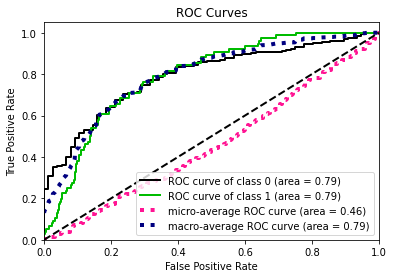

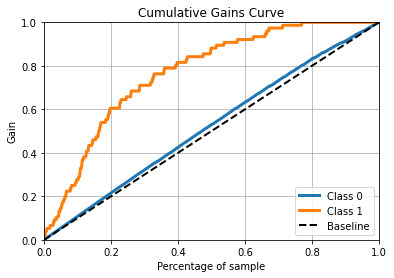

In [ ]:
from sklearn.metrics import confusion_matrix
#Best: 0.852759 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result_cmsi.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result_cmsi.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_roc_curve(y_test, y_test_predict_proba)
skplot.metrics.plot_cumulative_gain(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))
y_test.value_counts()

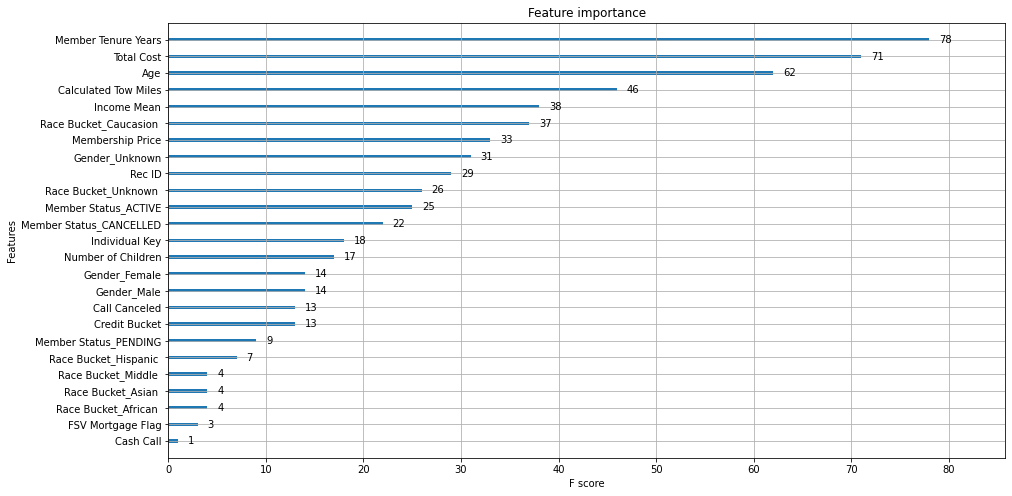

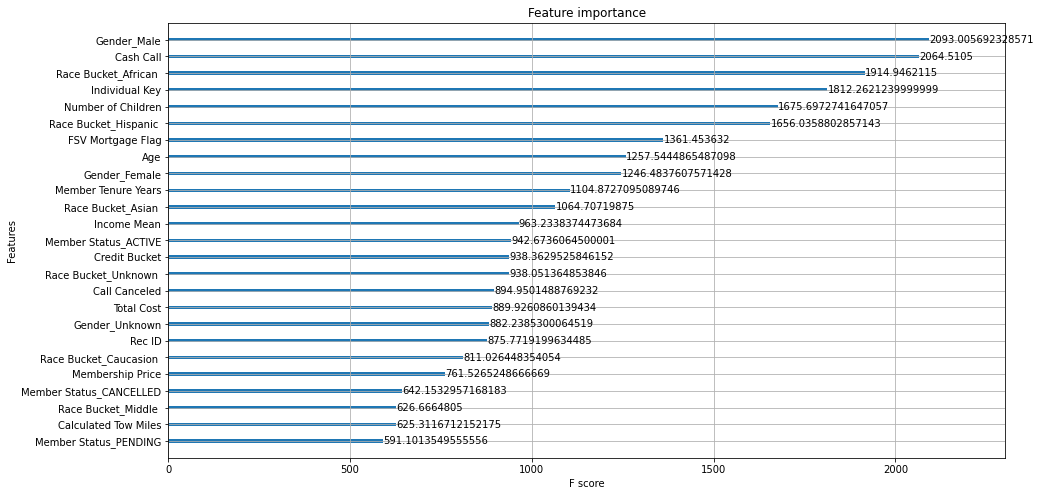

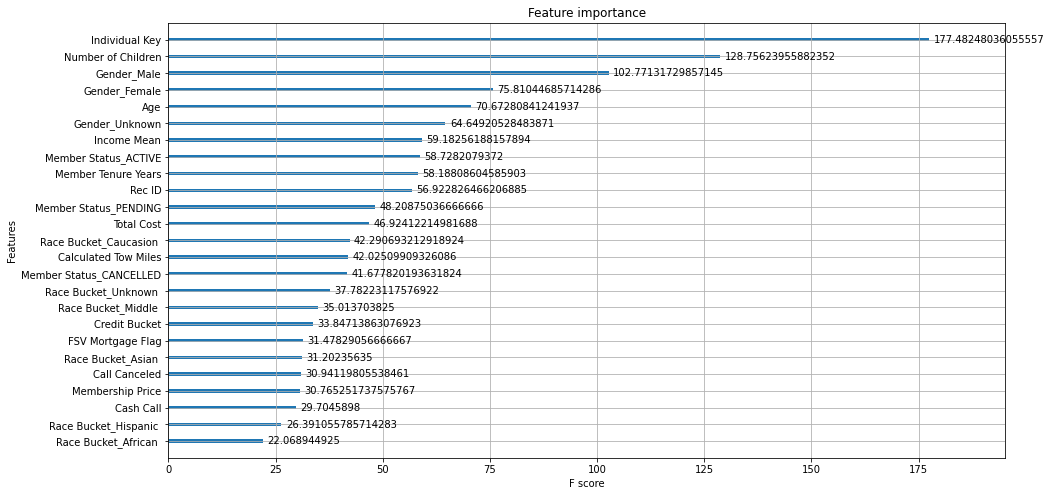

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot
y_test_predict = grid_result_cmsi.predict(X_test.set_index('Household Key'))
confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure
fig.set_size_inches(15,8)

ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure
fig.set_size_inches(15,8)

ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure
fig.set_size_inches(15,8)

In [ ]:
#Best: 0.567730 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
#Best: 0.965325 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
X_train.set_index('Household Key').columns
y_test_predict = grid_result_credit.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict))

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()

In [ ]:
#need sampling method to tackle this issue


# for reproducibility purposes
seed = 100
# SMOTE number of neighbors
k = 5

cat_list=list(range(14)) #categorical features in the dataset there are 15 
from imblearn.over_sampling import SMOTENC
sm = SMOTENC(categorical_features=cat_list,sampling_strategy=0.7, k_neighbors=k, random_state=seed)

#Upsample to get 70% of minority class
from collections import Counter
X_res, y_res =sm.fit_resample(X_train, y_train)
print(sorted(Counter(y_res).items()))


In [ ]:
dict_y=list(Counter(y_res).items())
items=round(dict_y[0][1]*0.7)
items

2730

In [ ]:
col_list=list(X_new.columns)
col_list.append("FSV CMSI Flag")
#col_list.insert(0,"Household Key")


X_Y_res = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
X_Y_res.columns=col_list
X_downsampled=X_Y_res[X_Y_res['FSV CMSI Flag']==0].sample(items)

new_Df=pd.concat([X_Y_res[X_Y_res['FSV CMSI Flag']==1], X_downsampled], axis=0)
X_test

In [ ]:
cols=X_test.drop(columns=['FSV Mortgage Flag','Household Key']).columns
cols

In [ ]:

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

def adaboost(X_train, X_test, y_train):
    model = AdaBoostClassifier(n_estimators=100, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test) 
    Y_probs=model.predict_proba(X_test)
    print(cols,model.feature_importances_)
    return y_pred, Y_probs

#smotenc+adaboost
y_smote, ysmote_probs = adaboost(X_res, X_test, y_res)

# RUS + adaboost 
X_full = X_train.drop(columns=['FSV Mortgage Flag','Household Key']).copy()
X_full['target'] = y_train
X_maj = X_full[X_full.target==0]
X_min = X_full[X_full.target==1]
X_maj_rus = resample(X_maj,replace=False,n_samples=len(X_min),random_state=44)
X_rus = pd.concat([X_maj_rus, X_min])
X_train_rus = X_rus.drop(['target'], axis=1)
y_train_rus = X_rus.target
y_rus, y_rusprobs = adaboost(X_train_rus, X_test.drop(columns=['FSV Mortgage Flag','Household Key']), y_train_rus)
 

#Smotenc+logreg and svm
lr=LogisticRegression(penalty='l2', C=4, dual=False, max_iter=10000)
clf = LinearSVC(penalty='l2', max_iter=500, dual=False, C=10,verbose=1)
clf.fit(new_Df.drop(columns=["FSV CMSI Flag",'FSV Mortgage Flag','Household Key']), new_Df['FSV CMSI Flag'])
lr.fit(new_Df.drop(columns=["FSV CMSI Flag",'FSV Mortgage Flag','Household Key']), new_Df['FSV CMSI Flag'])

print("SVM",clf.score(X_test.drop(columns=['FSV Mortgage Flag','Household Key']),y_test))
print("Log Reg",lr.score(X_test.drop(columns=['FSV Mortgage Flag','Household Key']),y_test))

y_pred = lr.predict(X_test.drop(columns=['FSV Mortgage Flag','Household Key']))
y_predsvm=clf.predict(X_test.drop(columns=['FSV Mortgage Flag','Household Key']))

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_matlr = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matsvm= confusion_matrix(y_true=y_test, y_pred=y_predsvm)
conf_mat_adasmote= confusion_matrix(y_true=y_test, y_pred=y_smote)
conf_mat_rusada= confusion_matrix(y_true=y_test, y_pred=y_rus)
print('Confusion matrix:\n', conf_matlr)
print('Confusion matrix:\n', conf_matsvm)
print('Confusion matrix:\n', conf_mat_adasmote)
print('Confusion matrix:\n', conf_mat_rusada)

target_names = ['Not Bought', 'Bought']

#print('log Report:\n',classification_report(y_test, y_pred, target_names=target_names))

#print('svm Report:\n',classification_report(y_test, y_predsvm, target_names=target_names))

#print('smote ada Report:\n',classification_report(y_test, y_smote, target_names=target_names))
print('rus ada Report:\n',classification_report(y_test, y_rus, target_names=target_names))


'''
[LibLinear]SVM 0.9070860448300795
Log Reg 0.9070860448300795
Confusion matrix:
 [[2509    0]
 [ 257    0]]
 '''
skplot.metrics.plot_cumulative_gain(y_test, y_rusprobs)
skplot.metrics.plot_roc_curve(y_test, y_rusprobs)
skplot.metrics.plot_lift_curve(y_test, y_rusprobs)


##Credit Card Classifier



In [ ]:
#

print(product_cols)
print(Household_ads['FSV Credit Card Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV Credit Card Flag']
col_list=list(X_new.columns).append('FSV Credit Card Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)
y_test.value_counts()

['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.889716
1    0.110284
Name: FSV Credit Card Flag, dtype: float64


0    933
1    116
Name: FSV Credit Card Flag, dtype: int64

In [ ]:

params={'n_estimators': [50, 100],
 'max_depth': [4, 6],
 'scale_pos_weight': [ 8,20, 50, 100],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model_credit = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model_credit, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result_credit = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result_credit.best_score_, grid_result_credit.best_params_))
# report all configurations
means = grid_result_credit.cv_results_['mean_test_score']
stds = grid_result_credit.cv_results_['std_test_score']
params = grid_result_credit.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.965325 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.583611 (0.067851) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.876611 (0.046373) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 20}
0.945883 (0.033311) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.965325 (0.024157) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.499337 (0.070767) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.795082 (0.067938) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 20}
0.877320 (0.0556

[[105 828]
 [  7 109]]
              precision    recall  f1-score   support

  Not Bought       0.94      0.11      0.20       933
      Bought       0.12      0.94      0.21       116

    accuracy                           0.20      1049
   macro avg       0.53      0.53      0.20      1049
weighted avg       0.85      0.20      0.20      1049



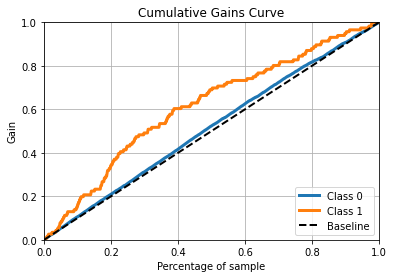

In [ ]:
#Best: 0.760046 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}

#Best: 0.963506 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result_credit.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result_credit.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_cumulative_gain(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))

[[105 828]
 [  7 109]]


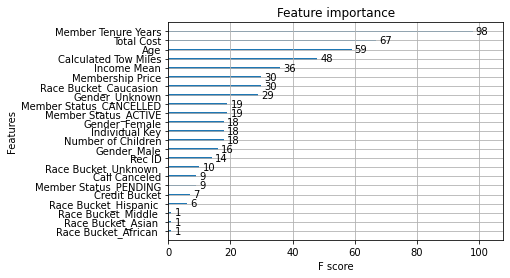

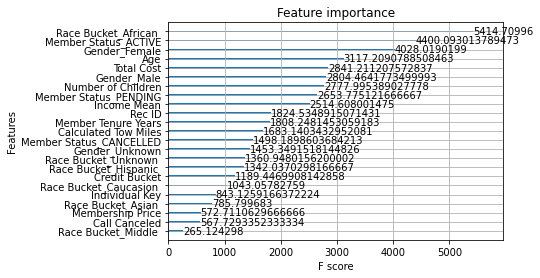

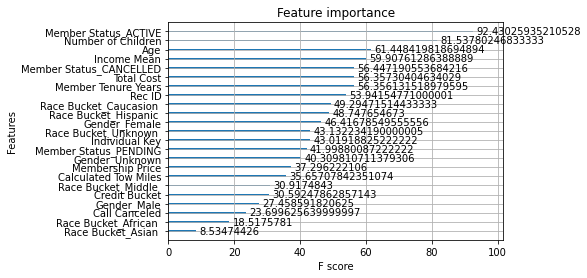

In [ ]:
#Best: 0.567730 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
#Best: 0.965325 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
X_train.set_index('Household Key').columns
y_test_predict = grid_result_credit.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict))

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()

##Theft ID purchasing likelihood

In [ ]:
print(product_cols)
print(Household_ads['FSV ID Theft Flag'].value_counts(normalize=True))
y_new = Household_ads['FSV ID Theft Flag']
col_list=list(X_new.columns).append('FSV ID Theft Flag')
#transformed_df
X_train, X_test, y_train, y_test = train_test_split(transformed_df.reset_index(), y_new, test_size=0.2, random_state=0)

['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag', 'FSV Home Equity Flag', 'FSV ID Theft Flag', 'TRV Globalware Flag', 'INS Client Flag']
0    0.955161
1    0.044839
Name: FSV ID Theft Flag, dtype: float64


In [ ]:

params={'n_estimators': [50, 100],
 'max_depth': [4],
 'scale_pos_weight': [ 8, 20, 50],
 'alpha':[5],
 'learning_rate':[0.1],
 'random_state': [13]}
model = XGBClassifier(objective='binary:logistic', booster='gbtree', colsample_bytree= 0.3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=cv, scoring='recall')  
grid_result_theft = grid.fit(X_train.set_index('Household Key'), y_train)        

print("Best: %f using %s" % (grid_result_theft.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result_theft.cv_results_['mean_test_score']
stds = grid_result_theft.cv_results_['std_test_score']
params = grid_result_theft.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.695517 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 100}
0.012671 (0.026696) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 8}
0.431384 (0.121938) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 20}
0.695517 (0.115359) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.043372 (0.043245) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 8}
0.335088 (0.104302) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 20}
0.579337 (0.130918) with: {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'scale_pos_weight': 50}


[[535 463]
 [ 12  39]]
              precision    recall  f1-score   support

  Not Bought       0.98      0.54      0.69       998
      Bought       0.08      0.76      0.14        51

    accuracy                           0.55      1049
   macro avg       0.53      0.65      0.42      1049
weighted avg       0.93      0.55      0.67      1049



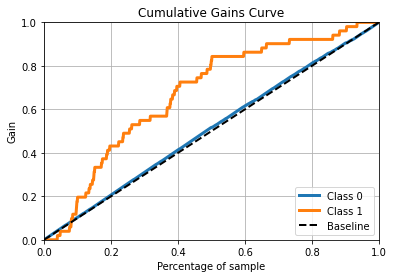

In [ ]:
from sklearn.metrics import confusion_matrix

!pip install scikit-plot
import scikitplot as skplot
from sklearn.metrics import classification_report
X_train.set_index('Household Key').columns
y_test_predict = grid_result_theft.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict, labels=[0,1]))

feat_imp=grid.best_estimator_.feature_importances_
# plot

y_test_predict_proba = grid_result_theft.predict_proba(X_test.set_index('Household Key'))
target_names = ['Not Bought', 'Bought']
skplot.metrics.plot_cumulative_gain(y_test, y_test_predict_proba)
print(classification_report(y_test,y_test_predict, target_names=target_names))

[[535 463]
 [ 12  39]]


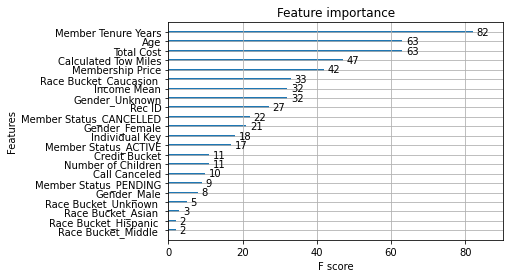

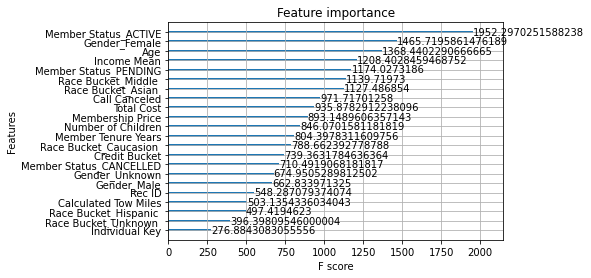

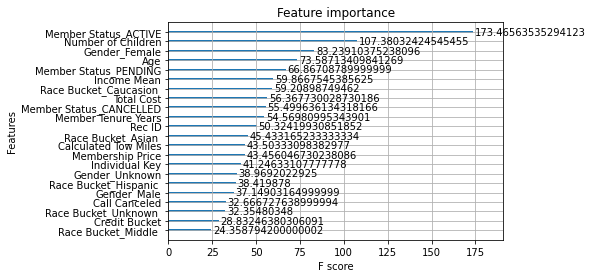

In [ ]:
#Best: 0.695517 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
X_train.set_index('Household Key').columns
y_test_predict = grid_result_theft.predict(X_test.set_index('Household Key'))
print(confusion_matrix(y_true=y_test, y_pred=y_test_predict))

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.set_index('Household Key').columns
feat_imp.set_index('Columns', inplace=True)

plot_importance(grid.best_estimator_)
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'cover')
pyplot.show()

plot_importance(grid.best_estimator_, importance_type= 'gain')
pyplot.show()

##Models for predicting Total cost and Total Rec ID

In [ ]:
Reg_house_ads=Household_ads.set_index('Household Key')
Reg_house_ads

In [ ]:
#building an analytical dataset for the household- 
#we characterize that to make our purchasing decision since the desparity of classes will be lower
Reg_house_ads=member_df_dummies.groupby(['Household Key']).agg({'Individual Key':'count','Rec ID':"count",'Total Cost': "mean",
                                                  'Member Tenure Years': "mean",
                                                  'ERS Member Cost Year 1': "mean", 
                                                  'ERS Member Cost Year 2':"mean",
                                                 'ERS Member Cost Year 3':"mean",
                                                 'ERS ENT Count Year 1': "mean", 
                                                 'ERS ENT Count Year 2': "mean",
                                                 'ERS ENT Count Year 3': "mean",
                                                 'Call Canceled': "sum", 
                                                 'Cash Call': "sum",
                                                 'Number of Children': "sum",
                                                 'Income Mean': "mean",
                                                 'Calculated Tow Miles': "sum",
                                                 'Membership Price': "mean",
                                                 'Age': "max",
                                                 'Credit Bucket':'max',
                                                 'Race Bucket_Caucasion ':'sum',
                                                 'Race Bucket_Hispanic ': 'sum'
                                                 ,'Race Bucket_Middle ': 'sum', 
                                                 'Race Bucket_Unknown ': 'sum',
                                                  'Race Bucket_African ': 'sum',
                                                   'Race Bucket_American ': 'sum',
                                                   'Race Bucket_Asian ': 'sum',
                                                    'Gender_Female': 'sum',
                                                    'Gender_Male': 'sum',
                                                     'Gender_Unknown': 'sum',
                                                      'Member Status_ACTIVE': 'sum',
                                                       'Member Status_CANCELLED': 'sum', 
                                                       'Member Status_PENDING': 'sum',
                                                       'FSV CMSI Flag': 'sum',
                                                       'FSV Credit Card Flag': 'sum',
                                                       'FSV Deposit Program Flag': 'sum',
                                                         'FSV Home Equity Flag': 'sum',
                                                         'FSV ID Theft Flag': 'sum',
                                                          'FSV Mortgage Flag': 'sum',
                                                          'TRV Globalware Flag': 'sum',
                                                          'INS Client Flag': 'sum',

                                                  }).reset_index()
                                                                                                

#member_ads.drop('FSV Mortgage Flag', inplace=True)
def flag_prod(x):
  if x>0:return 1
  else: return 0

Reg_house_ads.fillna(0,inplace=True)

product_cols=['FSV Credit Card Flag', 'FSV CMSI Flag', 'FSV Deposit Program Flag','FSV Home Equity Flag', 
               'FSV ID Theft Flag','TRV Globalware Flag','INS Client Flag']
Reg_house_ads.set_index('Household Key', inplace=True)

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Reg_house_ads.drop(['ERS Member Cost Year 3','ERS ENT Count Year 3','Rec ID', 'Total Cost'], axis=1)
y_new = Reg_house_ads['ERS Member Cost Year 3']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=X_new.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('ERS Member Cost Year 3')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)

#print(len(y_train))
#print(len(y_test))
transformed_df
X_train

,Individual Key,Member Tenure Years,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS ENT Count Year 1,ERS ENT Count Year 2,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16616199.0,-1.450415,0.620867,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-0.314398,0.806857,-0.679271,0.641213,-0.106266,-2.672082,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,-0.652816,-1.556380,-0.028711,-1.339634,-0.294012,-0.274806,2.837409,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
5144534.0,-0.494113,0.582826,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,0.640923,-0.110935,-0.679271,0.641213,0.433402,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
7295976.0,-0.494113,-1.845629,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,0.141705,-2.215077,-0.679271,0.641213,-0.170611,-1.146150,-1.105988,-0.219067,5.786213,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-1.128362,0.016055,3.398949,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
13728273.0,-1.450415,0.469071,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.643503,-0.281583,-1.105988,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,-0.345496,-1.128362,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
195448.0,0.075152,-0.004839,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.106266,-0.281583,-1.105988,-0.219067,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.684396,0.487968,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40682673.0,-0.494113,0.850354,-0.532621,1.334221,-0.529757,1.350199,-0.402277,-0.130681,0.141705,-2.755534,1.531958,0.641213,0.575188,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.611069,-1.556380,0.487968,-1.339634,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,1.716480
13029984.0,1.532353,-0.346818,-0.532621,1.503314,-0.529757,1.693712,2.490646,-0.130681,-1.238934,0.221013,1.735424,-1.665352,0.575188,-0.281583,-1.105988,-0.219067,-0.172825,2.053379,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,1.917640,1.333967,-1.339634,3.402636,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
6117070.0,1.626365,-1.259888,-0.532621,1.364460,-0.529757,1.350199,-0.402277,-0.130681,0.929371,0.552744,1.616179,-0.837821,-0.421009,-0.281583,1.435184,-0.219067,-0.172825,1.474676,-0.06032,-0.051753,-0.102983,1.737876,-0.652816,1.213923,1.333967,1.659804,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,1.716480


In [ ]:
#building a regressor

from xgboost import XGBRegressor


params={'n_estimators': [100, 500],
 'max_depth': [4],
 'alpha':[5, 10],
 'learning_rate':[0.1],
 'random_state': [13], 
 'reg_lambda':[0.02,0.05,0.1],
 'gamma':[2,5,10]
 }
model = XGBRegressor(colsample_bytree= 0.3, importance_type='gain', verbose=0,)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=0)  
grid_result_reg_cost = grid.fit(X_train, y_train)        

print("Best: %f using %s" % (grid_result_reg_cost.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result_reg_cost.cv_results_['mean_test_score']
stds = grid_result_reg_cost.cv_results_['std_test_score']
params = grid_result_reg_cost.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:05:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:06:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: 0.229235 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
0.224158 (0.054067) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.02}
0.229235 (0.053750) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.05}
0.228510 (0.052005) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.1}
0.170863 (0.060264) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
0.173382 (0.069743) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lam

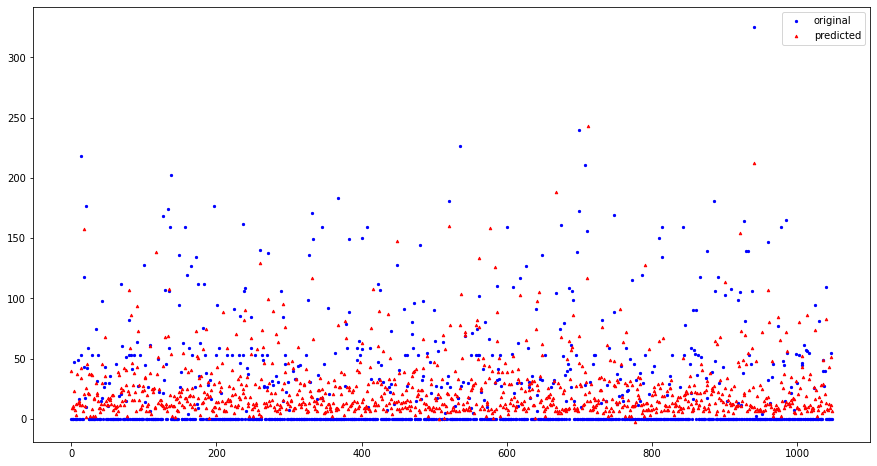

In [ ]:
#Best: R2=0.822854 using {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
#Best: 0.229235 using {'alpha': 5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 13, 'scale_pos_weight': 50}
#0.224158 (0.054067) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.02}
#X_train.set_index('Household Key').columns
y_test_predict = grid_result_reg_cost.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot
#y_test_predict = grid_result.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.columns
feat_imp.set_index('Columns', inplace=True)

x_ax = range(len(y_test))
plt.figure(figsize=(15,8))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original", marker="o")
plt.scatter(x_ax, y_test_predict, s=6, color="red", label="predicted",marker="^",)
plt.legend()
plt.show()


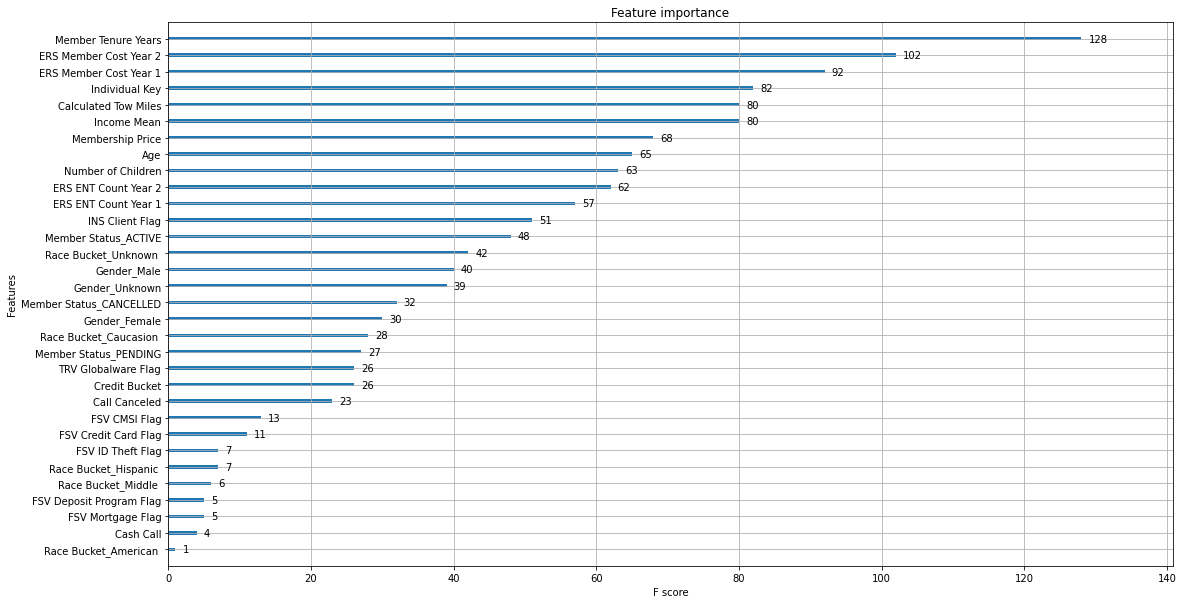

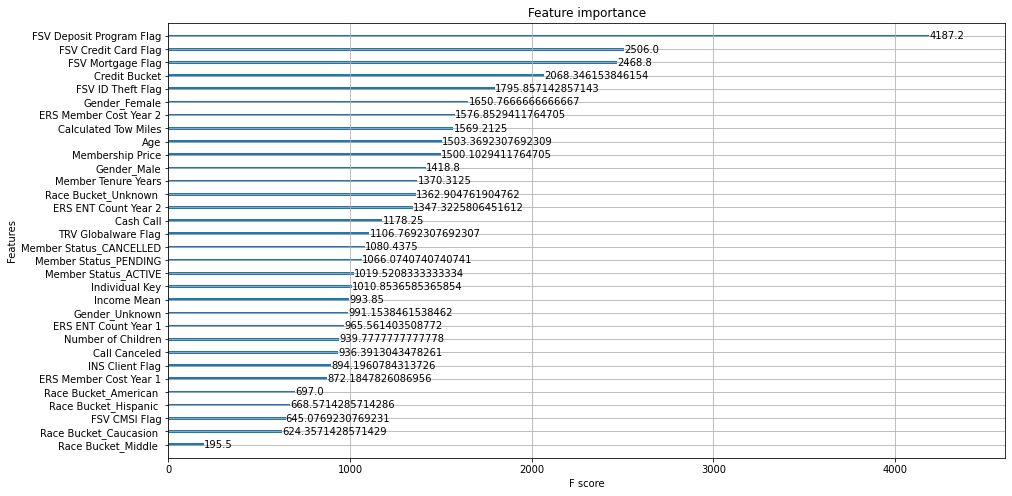

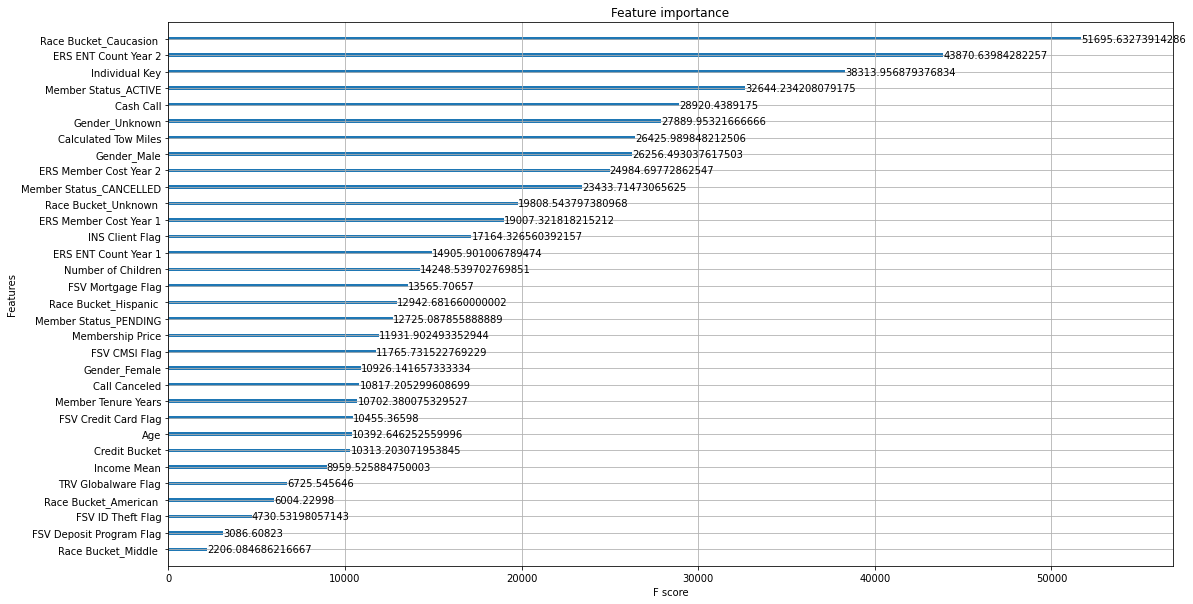

In [ ]:
#ax = xgboost.plot_importance(...)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure
fig.set_size_inches(18, 10)


ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure
fig.set_size_inches(15, 8)


ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure
fig.set_size_inches(18, 10)



In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

X_new = Reg_house_ads.drop(['ERS Member Cost Year 3','ERS ENT Count Year 3','Rec ID', 'Total Cost'], axis=1)
y_new = Reg_house_ads['ERS ENT Count Year 3']
transformed_df=pt.fit_transform(X_new)
transformed_df=pd.DataFrame(transformed_df, index=X_new.index, columns=X_new.columns)
#transformed_df.columns=X_new.columns
transformed_df
col_list=list(X_new.columns).append('ERS ENT Count Year 3')
#splitting into training and test
X_train, X_test, y_train, y_test = train_test_split(transformed_df, y_new, test_size=0.2, random_state=0)

#print(len(y_train))
#print(len(y_test))
transformed_df
X_train

,Individual Key,Member Tenure Years,ERS Member Cost Year 1,ERS Member Cost Year 2,ERS ENT Count Year 1,ERS ENT Count Year 2,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16616199.0,-1.450415,0.620867,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-0.314398,0.806857,-0.679271,0.641213,-0.106266,-2.672082,0.083218,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,-0.652816,-1.556380,-0.028711,-1.339634,-0.294012,-0.274806,2.837409,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
5144534.0,-0.494113,0.582826,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,0.640923,-0.110935,-0.679271,0.641213,0.433402,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-0.028711,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
7295976.0,-0.494113,-1.845629,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,0.141705,-2.215077,-0.679271,0.641213,-0.170611,-1.146150,-1.105988,-0.219067,5.786213,-1.299902,-0.06032,-0.051753,-0.102983,0.970957,1.298394,-1.556380,-1.128362,0.016055,3.398949,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
13728273.0,-1.450415,0.469071,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,1.643503,-0.281583,-1.105988,-0.219067,-0.172825,0.006286,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,-0.345496,-1.128362,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
195448.0,0.075152,-0.004839,-0.532621,-0.755684,-0.529757,-0.737792,-0.402277,-0.130681,-1.238934,0.221013,-0.679271,0.641213,-0.106266,-0.281583,-1.105988,-0.219067,-0.172825,1.004101,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,0.684396,0.487968,0.016055,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,2.460080,-0.613268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40682673.0,-0.494113,0.850354,-0.532621,1.334221,-0.529757,1.350199,-0.402277,-0.130681,0.141705,-2.755534,1.531958,0.641213,0.575188,-1.146150,0.613767,-0.219067,-0.172825,-1.299902,-0.06032,-0.051753,-0.102983,-0.780776,1.611069,-1.556380,0.487968,-1.339634,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,1.716480
13029984.0,1.532353,-0.346818,-0.532621,1.503314,-0.529757,1.693712,2.490646,-0.130681,-1.238934,0.221013,1.735424,-1.665352,0.575188,-0.281583,-1.105988,-0.219067,-0.172825,2.053379,-0.06032,-0.051753,-0.102983,-0.780776,-0.652816,1.917640,1.333967,-1.339634,3.402636,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,-0.613268
6117070.0,1.626365,-1.259888,-0.532621,1.364460,-0.529757,1.350199,-0.402277,-0.130681,0.929371,0.552744,1.616179,-0.837821,-0.421009,-0.281583,1.435184,-0.219067,-0.172825,1.474676,-0.06032,-0.051753,-0.102983,1.737876,-0.652816,1.213923,1.333967,1.659804,-0.294012,-0.274806,-0.352072,-0.073288,-0.033855,-0.216665,-0.045861,-0.402585,1.716480


In [ ]:
params={'n_estimators': [100, 500],
 'max_depth': [4],
 'alpha':[5, 10],
 'learning_rate':[0.1],
 'random_state': [13], 
 'reg_lambda':[0.02,0.05,0.1],
 'gamma':[2,5,10]
 }
model = XGBRegressor(colsample_bytree= 0.3, importance_type='gain', verbose=0,)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=0)  
grid_result_cnt_reg = grid.fit(X_train, y_train)        

print("Best: %f using %s" % (grid_result_cnt_reg.best_score_, grid_result_cnt_reg.best_params_))
# report all configurations
means = grid_result_cnt_reg.cv_results_['mean_test_score']
stds = grid_result_cnt_reg.cv_results_['std_test_score']
params = grid_result_cnt_reg.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:07:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[01:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: 0.249306 using {'alpha': 5, 'gamma': 10, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.05}
0.239001 (0.056128) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.02}
0.241080 (0.056399) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.05}
0.240895 (0.051737) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 13, 'reg_lambda': 0.1}
0.224527 (0.062163) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
0.230741 (0.060592) with: {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13

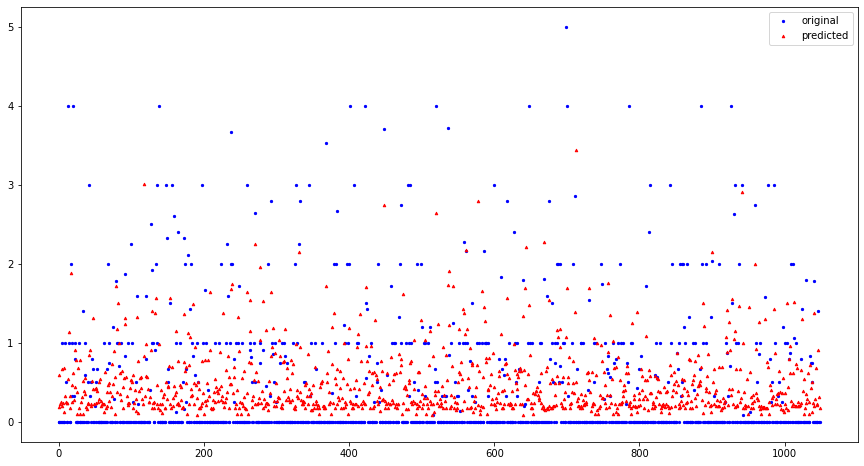

In [ ]:
#Best: R2=0.822854 using {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
#Best: 0.822854 using {'alpha': 5, 'gamma': 2, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'random_state': 13, 'reg_lambda': 0.02}
#X_train.set_index('Household Key').columns
y_test_predict = grid_result_cnt_reg.predict(X_test)
#confusion_matrix(y_true=y_test, y_pred=y_test_predict)

feat_imp=grid.best_estimator_.feature_importances_
# plot
y_test_predict

from xgboost import plot_importance
from matplotlib import pyplot

feat_imp=grid.best_estimator_.feature_importances_
# plot
#plt.bar(range(len(grid.best_estimator_.feature_importances_)), grid.best_estimator_.feature_importances_)
#plt.show()
feat_imp=pd.DataFrame(feat_imp)
feat_imp['Columns']=X_train.columns
feat_imp.set_index('Columns', inplace=True)

x_ax = range(len(y_test))
plt.figure(figsize=(15,8))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original", marker="o")
plt.scatter(x_ax, y_test_predict, s=6, color="red", label="predicted",marker="^",)
plt.legend()
plt.show()


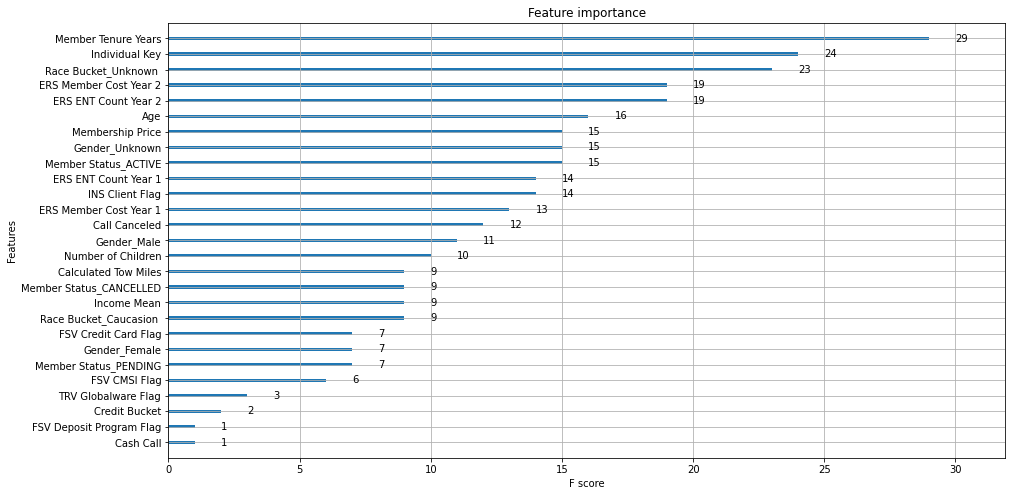

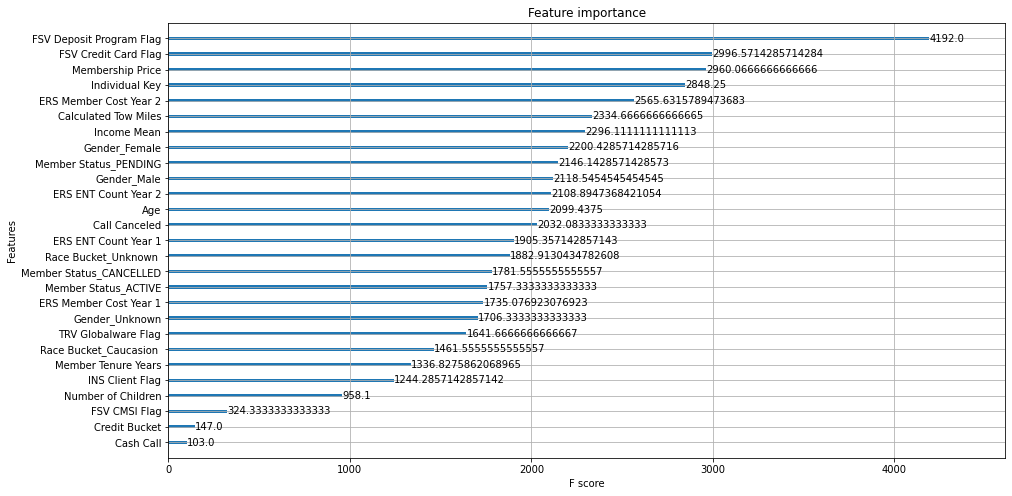

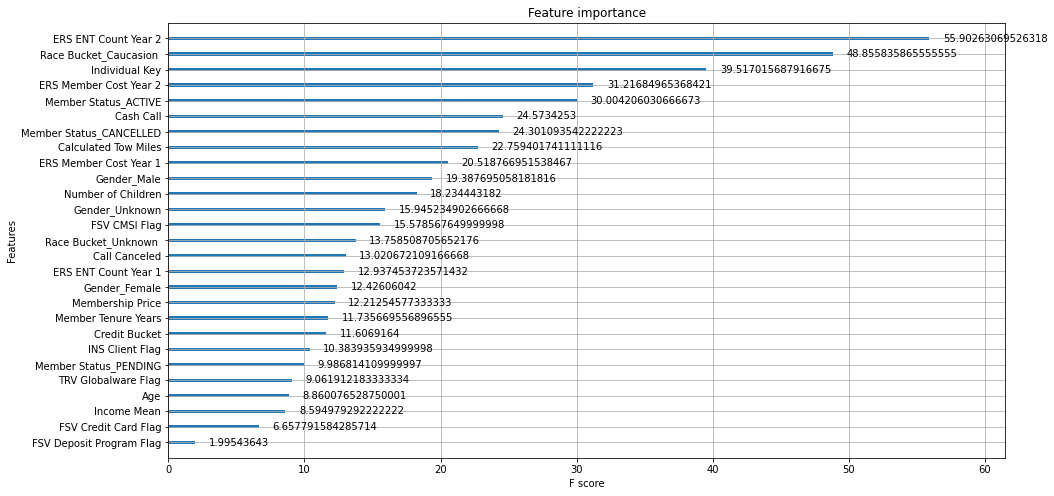

In [ ]:
#ax = xgboost.plot_importance(...)

ax=plot_importance(grid.best_estimator_)
fig = ax.figure
fig.set_size_inches(15, 8)


ax2=plot_importance(grid.best_estimator_, importance_type= 'cover')
fig = ax2.figure
fig.set_size_inches(15, 8)


ax3=plot_importance(grid.best_estimator_, importance_type= 'gain')
fig = ax3.figure
fig.set_size_inches(15, 8)


##putting everything together

In [ ]:
product_cols=['FSV Credit Card Flag',
 'FSV CMSI Flag',
 'FSV Deposit Program Flag',
 'FSV Home Equity Flag',
 'FSV ID Theft Flag',
 'TRV Globalware Flag',
 'INS Client Flag']

In [ ]:
Household_ads

,Household Key,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV CMSI Flag,FSV Credit Card Flag,FSV Deposit Program Flag,FSV Home Equity Flag,FSV ID Theft Flag,FSV Mortgage Flag,TRV Globalware Flag,INS Client Flag
0,875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,1,0,0,0,0,0,0
1,969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0,0,0,0,0,0,1
2,3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0,0,0,0,0,0,0
3,8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,0,0,0,0,0,1,0
4,11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,0,0,0,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0,0,0,0,0,0,2
5237,100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0,0,0,0,0,0,0
5238,100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0,0,0,0,0,0,0
5239,100071870.0,7,6,35.166667,13.000000,0,0,0.0,58311.510927,9.0,59.000000,100.0,2.537858,0,0,0,7.0,0,0,0,0,0,7.0,0,7.0,0,0,0,0,0,0,0,0,6


In [ ]:
#score flags first

product_df=Household_ads.set_index('Household Key')[product_cols]
cluster_1pass=Household_ads.drop(product_cols, axis=1).set_index('Household Key')
y_trv=pd.DataFrame(grid_result.predict_proba(cluster_1pass), index=cluster_1pass.index, columns=['TRV not bought Prob','TRV bought Prob']).drop('TRV not bought Prob', axis=1)
temp_df=cluster_1pass.join(y_trv, how='left')
temp_df
y_cmsi=pd.DataFrame(grid_result_cmsi.predict_proba(cluster_1pass), index=cluster_1pass.index, columns=['CMSI not bought Prob','CMSI bought Prob']).drop('CMSI not bought Prob', axis=1)
temp_df=temp_df.join(y_cmsi, how='left')
temp_df
y_credit=pd.DataFrame(grid_result_credit.predict_proba(cluster_1pass), index=cluster_1pass.index, columns=['Credit not bought Prob','Credit bought Prob']).drop('Credit not bought Prob', axis=1)
temp_df=temp_df.join(y_credit, how='left')
temp_df
y_theft=pd.DataFrame(grid_result_theft.predict_proba(cluster_1pass), index=cluster_1pass.index, columns=['Theft not bought Prob','Theft bought Prob']).drop('Theft not bought Prob', axis=1)
temp_df=temp_df.join(y_theft, how='left')
fin_df=temp_df.join(product_df, how='left')

fin_df['Credit bought Prob'] = np.where(fin_df['FSV Credit Card Flag']==0,fin_df['Credit bought Prob'],fin_df['FSV Credit Card Flag'])
fin_df['CMSI bought Prob'] = np.where(fin_df['FSV CMSI Flag']==0,fin_df['CMSI bought Prob'],fin_df['FSV CMSI Flag'])

fin_df['TRV bought Prob'] = np.where(fin_df['TRV Globalware Flag']==0,fin_df['TRV bought Prob'],fin_df['TRV Globalware Flag'])
fin_df['Theft bought Prob'] = np.where(fin_df['FSV ID Theft Flag']==0,fin_df['Theft bought Prob'],fin_df['FSV ID Theft Flag'])
cluster_ads=fin_df.drop(product_cols, axis=1)
cluster_ads

,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag,TRV bought Prob,CMSI bought Prob,Credit bought Prob,Theft bought Prob
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,0.004883,0.031045,1.000000,0.087197
969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0.007562,0.271200,0.001302,0.021213
3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0.027284,0.286876,0.011753,0.130714
8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,1.000000,0.368030,0.017952,0.170566
11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,1.000000,0.346703,0.001107,0.084945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0.016541,0.495824,0.005322,0.026851
100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0.006824,0.013881,0.007067,0.087670
100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0.016663,0.217718,0.001282,0.044990


In [ ]:
!pip install fbprophet

In [ ]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
  
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 


scaler = StandardScaler() 
X_scaled = scaler.fit_transform(cluster_ads) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized, index=cluster_ads.index, columns=cluster_ads.columns)
X_normalized
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(cluster_ads)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5241 samples in 0.017s...
[t-SNE] Computed neighbors for 5241 samples in 0.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5241
[t-SNE] Computed conditional probabilities for sample 2000 / 5241
[t-SNE] Computed conditional probabilities for sample 3000 / 5241
[t-SNE] Computed conditional probabilities for sample 4000 / 5241
[t-SNE] Computed conditional probabilities for sample 5000 / 5241
[t-SNE] Computed conditional probabilities for sample 5241 / 5241
[t-SNE] Mean sigma: 5.323848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.610924
[t-SNE] KL divergence after 300 iterations: 0.940397


In [ ]:
cluster_ads['tsne-2d-one'] = tsne_results[:,0]
cluster_ads['tsne-2d-two'] = tsne_results[:,1]

cluster_ads['tsne-2d-3'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
cluster_ads

,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag,TRV bought Prob,CMSI bought Prob,Credit bought Prob,Theft bought Prob,tsne-2d-one,tsne-2d-two,tsne-2d-3
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,0.004883,0.031045,1.000000,0.087197,4.001828,4.322480,4.322480
969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0.007562,0.271200,0.001302,0.021213,0.918211,5.896076,5.896076
3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0.027284,0.286876,0.011753,0.130714,6.572045,-6.890332,-6.890332
8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,1.000000,0.368030,0.017952,0.170566,7.482461,-2.093138,-2.093138
11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,1.000000,0.346703,0.001107,0.084945,-7.082867,0.016040,0.016040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0.016541,0.495824,0.005322,0.026851,-3.463605,3.281194,3.281194
100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0.006824,0.013881,0.007067,0.087670,1.068275,0.697697,0.697697
100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0.016663,0.217718,0.001282,0.044990,-4.106870,-5.324304,-5.324304


<Figure size 1152x720 with 0 Axes>

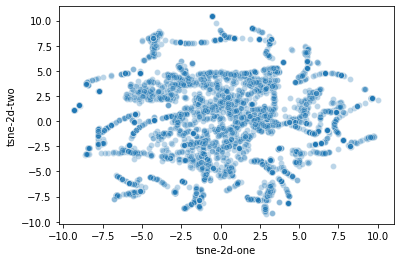

In [ ]:
sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two',
    palette=sns.color_palette("hls", 10),
    data=cluster_ads,
    legend="full",
    alpha=0.3)


fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter( x='tsne-2d-one', y='tsne-2d-two',z='tsne-2d-3' ,c=labels, )
#plot_2d_space(pca_df, y_train, 'Imbalanced dataset (2 PCA components)')
#plot_2d_space()

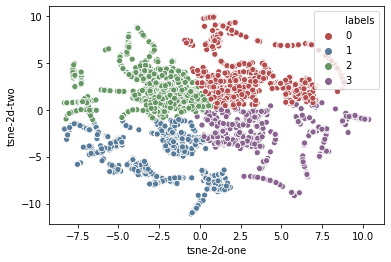

In [ ]:
from sklearn.cluster import KMeans
X_principal=cluster_ads[['tsne-2d-one','tsne-2d-two','tsne-2d-3']]
kmeans_cluster=KMeans(n_clusters=4,random_state=15).fit(X_principal)
labelsk = kmeans_cluster.labels_
df_clusterk=pd.DataFrame(labelsk, index=X_principal.index)
df_clusterk.columns=['labels']
df_clusterk['labels'].value_counts()
final_cluster=cluster_ads.join(df_clusterk, how='left')

sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two',hue='labels',
    palette=sns.color_palette("Set1", n_colors=4, desat=.5),
    data=final_cluster)


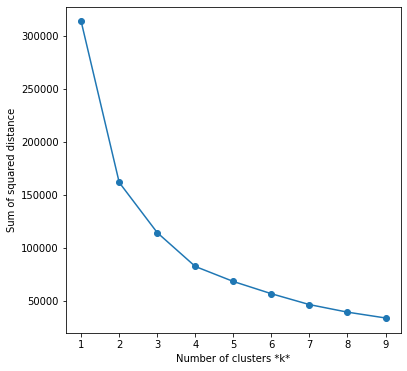

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_principal)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

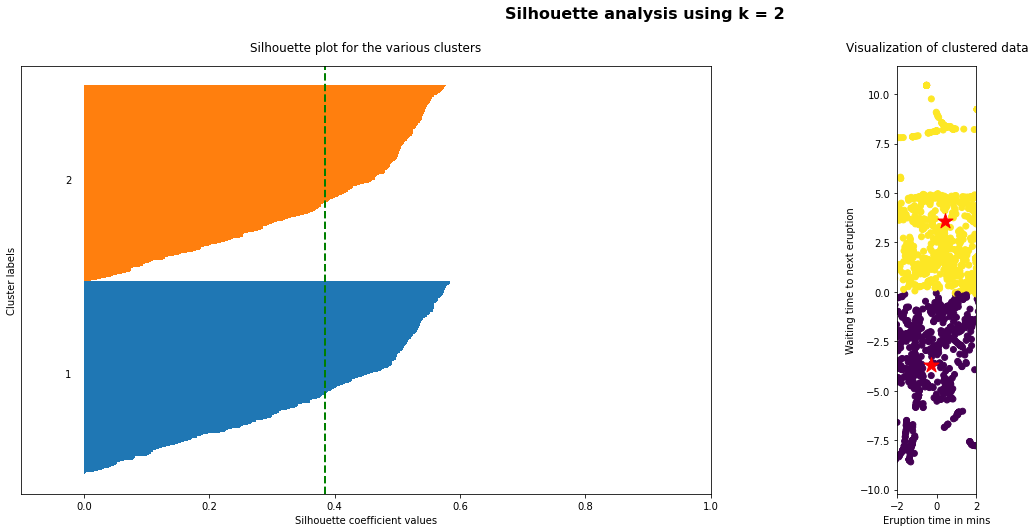

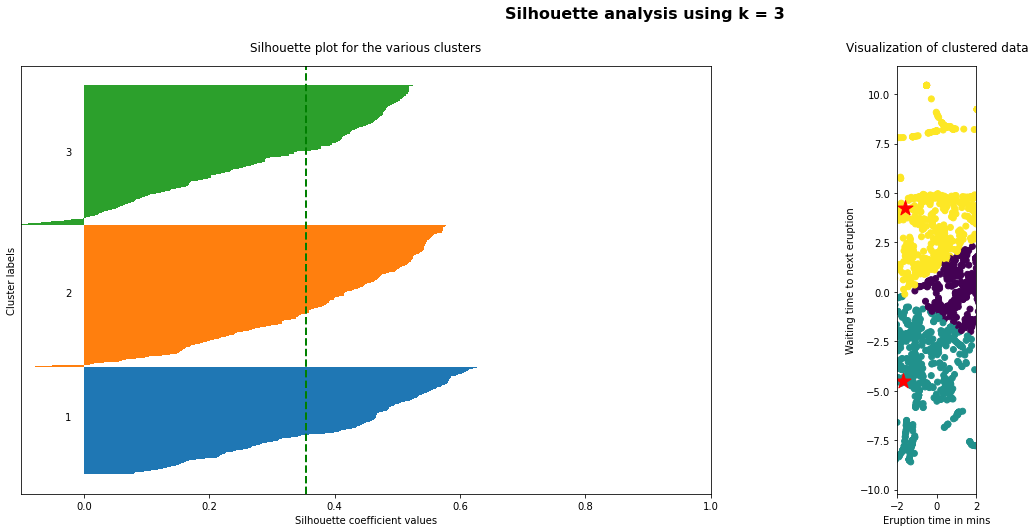

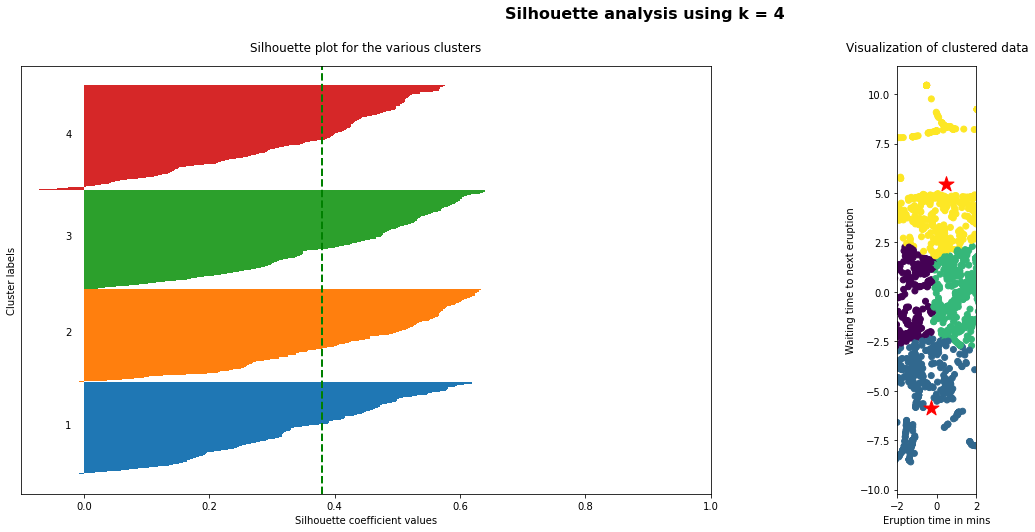

In [ ]:
X_principal=np.array(X_principal)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_principal)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_principal, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_principal[:, 0], X_principal[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Eruption time in mins')
    ax2.set_ylabel('Waiting time to next eruption')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05)

In [ ]:
 X_principal[:0 ]

,tsne-2d-one,tsne-2d-two,tsne-2d-3
Household Key,,,


In [ ]:
final_cluster

,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag,TRV bought Prob,CMSI bought Prob,Credit bought Prob,Theft bought Prob,tsne-2d-one,tsne-2d-two,tsne-2d-3,labels
Household Key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
875.0,18,14,75.942857,28.944444,0,0,0.0,58311.510927,112.2,87.055556,97.0,2.537858,0,0,0,18.0,0,0,0,0,0,18.0,9,4.0,5,0,0.087197,0.031045,1.000000,0.087197,-0.796429,-4.513552,-4.513552,3
969.0,6,4,56.525000,35.333333,1,0,2.0,55555.840618,9.0,89.000000,76.0,4.000000,1,0,0,4.0,0,0,0,1,2,3.0,6,0.0,0,0,0.021213,0.271200,0.001302,0.021213,-2.684751,-4.733510,-4.733510,3
3338.0,3,0,0.000000,37.333333,0,0,2.0,42209.173951,0.0,89.000000,89.0,2.537858,1,0,0,2.0,0,0,0,0,0,3.0,0,3.0,0,0,0.130714,0.286876,0.011753,0.130714,-7.842961,3.595995,3.595995,0
8718.0,2,0,0.000000,10.000000,0,0,1.0,44168.005463,0.0,89.000000,68.0,4.000000,1,0,0,1.0,0,0,0,0,1,1.0,1,1.0,0,0,1.000000,0.368030,0.017952,0.170566,-4.446482,6.117167,6.117167,2
11524.0,7,5,58.850000,36.285714,0,0,15.0,92933.071429,6.0,64.000000,75.0,3.000000,7,0,0,0.0,0,0,0,1,4,2.0,4,1.0,2,0,1.000000,0.346703,0.001107,0.084945,5.280758,0.771258,0.771258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100069201.0,2,2,53.000000,65.000000,0,0,2.0,58311.510927,12.0,54.000000,86.0,2.537858,0,0,0,0.0,0,0,0,2,0,0.0,2,0.0,0,0,0.026851,0.495824,0.005322,0.026851,-0.413886,2.790889,2.790889,2
100070004.0,4,2,30.000000,45.750000,0,0,0.0,58311.510927,4.1,104.000000,88.0,2.537858,0,0,0,4.0,0,0,0,0,0,4.0,0,4.0,0,0,0.087670,0.013881,0.007067,0.087670,-0.176626,-0.435120,-0.435120,0
100071861.0,10,8,55.925000,43.500000,0,0,8.0,27673.902185,4.0,61.000000,95.0,2.537858,8,0,0,2.0,0,0,0,0,0,10.0,8,2.0,0,0,0.044990,0.217718,0.001282,0.044990,4.082603,1.921464,1.921464,1


In [ ]:
final_cluster=final_cluster.round(decimals=2)

In [ ]:
final_cluster.groupby('labels').mean()

,Individual Key,Rec ID,Total Cost,Member Tenure Years,Call Canceled,Cash Call,Number of Children,Income Mean,Calculated Tow Miles,Membership Price,Age,Credit Bucket,Race Bucket_Caucasion,Race Bucket_Hispanic,Race Bucket_Middle,Race Bucket_Unknown,Race Bucket_African,Race Bucket_American,Race Bucket_Asian,Gender_Female,Gender_Male,Gender_Unknown,Member Status_ACTIVE,Member Status_CANCELLED,Member Status_PENDING,FSV Mortgage Flag,TRV bought Prob,CMSI bought Prob,Credit bought Prob,Theft bought Prob,tsne-2d-one,tsne-2d-two,tsne-2d-3
labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.473430,1.966184,26.417634,34.796965,0.149758,0.006039,4.050725,59335.718146,4.837198,82.111600,80.053140,2.760349,1.966184,0.155797,0.082126,1.173913,0.012077,0.008454,0.021739,0.869565,0.777778,1.826087,1.995169,1.269324,0.208937,0.004831,0.235356,0.401579,0.145442,0.144906,-4.378086,4.226449,4.226449
1,3.849383,2.594239,30.581758,36.032582,0.179424,0.032099,3.288066,51555.495782,4.522551,76.811286,72.781070,2.520226,1.431276,0.110288,0.065021,2.155556,0.001646,0.003292,0.026337,0.734979,0.665844,2.448560,2.062551,1.529218,0.257613,0.000823,0.229932,0.328935,0.131074,0.144446,0.278684,0.134760,0.134760
2,5.066600,3.616302,36.383126,36.979612,0.340954,0.107356,4.686879,50280.865862,10.487873,78.828659,68.572565,2.724447,2.137177,0.126243,0.120278,2.591451,0.006958,0.011928,0.027833,1.002982,0.931412,3.132207,2.762425,1.930417,0.373757,0.001988,0.244766,0.338462,0.115189,0.148478,0.692919,-6.054995,-6.054995
3,3.602258,2.247177,24.933783,39.631358,0.150565,0.018821,5.096612,82389.052533,5.013551,80.844832,81.848181,2.832659,2.214555,0.151819,0.102886,1.060226,0.012547,0.002509,0.030113,0.805521,0.885822,1.910916,2.165621,1.214555,0.222083,0.002509,0.219884,0.415459,0.092209,0.138310,2.833741,5.879265,5.879265
4,4.035242,2.657856,27.505183,41.977817,0.198238,0.014684,5.020558,48389.583581,6.306608,80.335054,81.196769,2.704903,2.311307,0.158590,0.077827,1.314244,0.002937,0.020558,0.045521,0.980910,0.803231,2.251101,2.337739,1.450808,0.246696,0.001468,0.223929,0.389464,0.112533,0.140189,6.665567,-0.376342,-0.376342
5,4.305322,2.768908,34.443695,35.977164,0.186275,0.018207,4.306723,49662.863272,6.491317,81.634807,76.203081,2.746827,2.043417,0.148459,0.068627,1.953782,0.001401,0.001401,0.022409,0.928571,0.750700,2.626050,2.175070,1.917367,0.211485,0.001401,0.213750,0.322128,0.138619,0.127473,-5.601014,-3.053908,-3.053908


In [ ]:
import files
final_cluster.to_csv('cluster.csv')
files.download('cluster.csv')

ModuleNotFoundError: ignored